![example](images/pexels-pixabay-40568.png)

# Phase 5 Project

**Author:** Freddy Abrahamson<br>
**Date created:** 8-14-2022<br>
**Discipline:** Data Science

## Overview

### In order for the notebook to run successfully:

1. Download the data from https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification
2. The folder should be downloaded to the same directory as where your Jupyter notebook is located. The folder is called 'archive'.
3. In order to recreate the necessary python environment, the environment.yml has been uploaded to github.
4. The notebook was run on macOS Big Sur (version 11.6) 

### About Retinal Diseases
According to the World Health Organization, atleast 2.2 billion people have some type of vision impairment, of which about half of these cases could have been prevented, or are yet to be addressed *. 

* https://www.who.int/news-room/fact-sheets/detail/blindness-and-visual-impairment

### Business Problem

<b>Stakeholder:</b> The Board of directors of a national network of  eye hospitals.

<b>Business Problem:</b> The hospital is looking for a solution that would enable the early detection and diagnosis of ocular diseases.  

<b>Proposed Solution:</b> A machine learning model that could distinguish between the image of a healthy retina, and of an unhealthy one. It can also detect for media haze (cloudy vision), and diabetic retinopathy.

<b>Solution Benefits:</b><br>
               1. cost effective<br> 
               2. non-invasive<br>
               3. would enable doctors to more effectively prevent, treat, and forestall the onset of ocular diseases

### Data Understanding and Data preparation

The data was taken from Kaggle.com. There are a total of 3200 images depicting healthy retinas, or retinas with a particular disease . The dataset is split into 3 subsets: training 60% (1920 images), evaluation 20% (640 images), and test 20% (640 images) sets. Each patient could potentially have more than one condition. I chose to work with the disease classes that 'occurred' in the training set at least 300 times.  Based on this criteria I was working with three different classes:<br><br>
                                                   Disease_Risk:                    1519<br>
                                                   DR (diabetic retinopathy):       376<br>
                                                   MH (media haze):                 317<br>

### Modeling

I used Keras and Tensorflow to create the models. Given that with the use of the filters, cnn(s) excel at detecting features of various sizes,I chose to use the less apt multi-layer perceptron as a baseline model. My modeling process was the following:
1. I tried to overfit on purpose using a cnn. Eventhough I was trying to overfit, I was also checking to see if that rise in the training score had any impact on the validation score. I began with a cnn model that has 4 activation layers for the feature extraction part,with the number of nodes for each layer being 16,32,64, and 128 respectively. I used ReLu as my activation function for all feature detection, as well as for the classification layers. Given that this is a a multi-label problem, I used three sigmoid functions in the output layer; one representing each class.<br><br>
2. From there, when I was satisfied with the model architecture(number of layers, and number of nodes per layer), I  would try to reduce the variance by using different combinations of filter sizes, with the goal of making the model more generalizable.<br><br>
3. Once I was satisifed with the filters, I would apply an optimizer with different learning rates, to see if this would improve results, or give me additional information about where the line plots for the scores of the respective data sets stopped oscillating, and possibly reach their respective convergences'.<br><br>
4. After this, I would choose the best model amongst these and try to further reduce the variance by using some regularization technique, such as adding a dropout layer(s), or using L1, or L2 regularization. 

### Evaluation

Given the importance of early detection of potential ocular diseases, my primary goal was to find a model that produced the best recall scores. To this end, I used a custom metric, 'recall_macro'. This metric returns the macro average of the respective recall scores of each class. So in this case, the metric would take the recall score of each of the three classes, add them up, and divide by three. In order to find the best model I took several factors into consideration:<br>
1. I was looking for a model that would produce one of the best,if not the best, bias/variance combination between the train and test data sets. I did this by creating a function best_model(), which utilizes the auc() function from sklearn.metrics. The x-axis is represented by the absolute difference between the train and test scores, while the y-axis is represented by the test scores. The higher the test score, and the lower the train-test difference, the greater the area under the curve. The function returns a dataframe with the models, and their respective test scores, sorted by their auc. The model with the highest auc is the best.<br><br>
2. The difference between the train and validation scores was also important. Ideally there would be some uniformity across all three scores, <br><br>
3. I also look at the recall/epoch plots to see if the train/val scores line up with any possible information that can be inferred from the plots.<br><br>
The secondary goal was a model that would have a macro accuracy score of atleast 70%. To this end, I created a custom metric, 'acc_macro', which takes the accuracy scores for each individual class, and returns the macro average.

# Import Modules

In [2]:
import os
import time
import shutil
import random
import itertools
import lime
from lime import lime_image
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.metrics
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, auc
from keras import models, layers, optimizers
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

<b>Creating random seeds for reproducibility.</b>

In [3]:
# set random seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Define Functions

## acc()

Takes as arguments:
 1. array of labels
 2. array of predictions
    
Returns the accuracy score.

In [163]:
def acc(y_true, y_pred):
    """
    Takes as arguments:
    1. array of labels
    2. array of predictions
    
    Returns the accuracy score.
    """
    from keras import backend as K

    # total = the total number of possible solutions:
    total = y_true.shape[0]
    # true positives (where both the actual value and the prdicted value equal 1)
    tp = K.sum(K.round(y_true * y_pred))
    # false positives (where the difference between the predicted value and the actual value equals 1) 
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    # false negatives (where the difference between the actual value and the predicted value equals 1) 
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    # true negatives (the difference between all four possible results, and the sum of other 3 possible results)
    tn = total - (tp + fp + fn)
    
    # epsilon is a very small number. It will be added to the 'total', if it's = 0, so as not to return an error.
    if total == 0:
        return  (tp + tn)/(total + K.epsilon())
    else:
        return  (tp + tn)/ total 

## acc_macro()

The acc_macro function measures the accuracy for each class, and then returns the macro average of all the classes. For example, if I have three classes A, B, and C. It would measure the average of each respective class, add them together, and divide by three. It is used as a custom metric when compiling the Keras models, but can also be used as a standalone function taking as its arguments the data-set labels, and the data-set predictions.

In [164]:
def acc_macro(y_true, y_pred):
    """
    The acc_macro function measures the accuracy for each class, and then returns the macro average of all the
    classes. It work in conjunction with the 'acc' function. For example, if I have three classes A, B, and C. It 
    would measure the accuracy of each respective class, add them together, and divide by three. It is used as a
    custom metric when compiling the Keras models, but can also be used as a stand-alone function taking as its
    arguments the data-set labels, and the data-set predictions. The definition is set up for a three class array.
    It would need to be modified if the number of classes were changed.
    """
    
    return (acc(y_true[:,0],y_pred[:,0]) + acc(y_true[:,1],y_pred[:,1])
    + acc(y_true[:,2],y_pred[:,2]))/3

## best_model()

The best_model function returns the best train test score combination based on the auc function, where
the difference between the test and the train scores represents the x axis, and test score represents
the y axis. In order use the auc function, for each x,y coordinate we created a list of length three,
with 0 and 1 at the ends, and the actual x,y values in the middle. The model with the highest auc score is the best. 

This function takes as as an argument an integer which represents the total number of models.


This function returns a dataframe with five columns:
  1. The model name
  2. The recall score for the train set
  3. The recall score for the test set
  4. The absolute value of the difference between the two scores
  5. The auc score, sorted in ascending order

In [165]:
def best_model(n):
    
    """
    The best_model function returns the best train test score combination based on the auc function, where
    the difference between the test and the train scores represents the x axis, and test score represents
    the y axis. In order use the auc function, for each x,y coordinate we created a list of length three,
    with 0 and 1 at the ends, and the actual x,y values in the middle. The model with the highest auc score is
    the best. 

    This function takes as as an argument an integer which represents the total number of models.


    This function returns a dataframe with eight columns:
    1. The model name
    2. The recall score for the train set
    3. The recall score for the validation set
    4. The recall score for the test set
    5. The absolute value of the difference between the train and the test scores.
    6. The absolute value of the difference between the train and the validation scores.
    7. The average of the train/val difference, and the train/test difference.
    8. The auc score, sorted in ascending order
    """
    
    
    
    from sklearn.metrics import auc
    scores_df = neural_network_model_scores_df(n)

#   creating 'test_scores' and 'score_diffs' zero populated lists of shape(rows,3) 
    rows = len(scores_df)
    test_scores = np.zeros((rows, 3))
    score_diffs = np.zeros((rows, 3))
    auc_scores = []

#   populating 'test_scores' and 'score_diffs' so each list has a format [0,test_score,1],
#   and [0,score_diff,1] respectively
    for row in range(rows):
        test_scores[row][1] = scores_df['test score'][row]
        test_scores[row][2] = 1
        score_diffs[row][1] = scores_df['train-test diff'][row]
        score_diffs[row][2] = 1

#   creating a list of all the auc scores
    for row in range(rows):
        auc_score = auc(score_diffs[row], test_scores[row])
        auc_scores.append(auc_score)
        
#   getting the greatest auc score, and the index number of that row    
    best_auc_score = max(auc_scores)
    best_score_index = auc_scores.index(best_auc_score)
    
#   add an auc_score cloumn to scores_df
    scores_df['auc score'] = auc_scores
    

#   return scores_df sprted by auc score
    return scores_df.sort_values(by='auc score', ascending=False)

## neural_network_model_scores_df()

This function takes as as an argument an integer which represents the total number of models.

This function returns a dataframe with four columns:
   1. The model name
   2. The recall score for the train set
   3. The recall score for the validation set
   4. The recall score for the test set
   5. The absolute value of the difference between the train and the test scores.
   6. The absolute value of the difference between the train and the validation scores.
   7. The average of the train/val difference, and the train/test difference.

In [166]:
def neural_network_model_scores_df (n):
    """
    This function takes as as an argument an integer which represents the total number of models.

    This function returns a dataframe with seven columns:
    1. The model name
    2. The recall score for the train set
    3. The recall score for the validation set
    4. The recall score for the test set
    5. The absolute value of the difference between the train and the test scores.
    6. The absolute value of the difference between the train and the validation scores.
    7. The average of the train/val difference, and the train/test difference.
    """
    
    
    count = 0
    model_dict ={}
    model_dict_list =[]
    while count<n:
        if count == 0:
            train_score = globals()['baseline_train_eval_dict']['recall_macro']
            val_score = globals()['baseline_val_eval_dict']['recall_macro']
            test_score = globals()['baseline_test_eval_dict']['recall_macro']
            model_name = 'baseline_model'
            model_dict = {'model name':model_name, 'train score':train_score, 'val score':val_score,
                          'test score':test_score}
            model_dict_list.append(model_dict)
            count+=1
        else:
            train_score = globals()['cnn_' +str(count) +'_train_eval_dict']['recall_macro']
            val_score = globals()['cnn_' +str(count) +'_val_eval_dict']['recall_macro']
            test_score = globals()['cnn_' +str(count) +'_test_eval_dict']['recall_macro']
            model_name = 'cnn_model_'+ str(count)
            model_dict = {'model name':model_name, 'train score':train_score, 'val score':val_score,
                          'test score':test_score}
            model_dict_list.append(model_dict)
            count+=1
    scores_df = pd.DataFrame(model_dict_list)
    scores_df['train-val diff'] = abs(scores_df['train score'] - scores_df['val score'])
    scores_df['train-test diff'] = abs(scores_df['train score'] - scores_df['test score'])
    scores_df['train-val-test diff mean'] = (scores_df['train-val diff'] + scores_df['train-test diff'])/2
    return scores_df

## plot_confusion_matrix()

Note: The code for this function was taken from the instructional website: https://deeplizard.com/learn/video/km7pxKy4UHU

This function takes the following arguments:
   1. cm: The array representing the results from the scikit-learn confusion_matrix() function
   2. classes: an array with the name of the class labels of the confusion matrix.
   3. normalize: if True, normalizes the values displayed by the confusion matrix. Default is False.
   4. title: The title of the confusion matrix. Default is 'Confusion Matrix'.
   5. cmap: Matplotlib colormap. Default is plt.cm.Blues.

This function returns a graphical plot of the confusion matrix. 

In [167]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    Note: The code for this function was taken from the instructional website:
    https://deeplizard.com/learn/video/km7pxKy4UHU

    This function takes the following arguments:
    1. cm: The array representing the results from the scikit-learn confusion_matrix() function
    2. classes: an array with the name of the class labels of the confusion matrix.
    3. normalize: if True, normalizes the values displayed by the confusion matrix. Default is False.
    4. title: The title of the confusion matrix. Default is 'Confusion Matrix'.
    5. cmap: Matplotlib colormap. Default is plt.cm.Blues.

    This function returns a graphical plot of the confusion matrix. 
    """
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## recall()

 Takes as arguments:
 1. array of labels
 2. array of predictions   
Returns the recall score.

In [168]:
def recall(y_true, y_pred): 
    """
    Takes as arguments:
    1. array of labels
    2. array of predictions
    
    Returns the recall score.
    """
#(recall class 1) do not use "round" here if you're going to use this as a loss function
    from keras import backend as K
    true_positives = K.sum(K.round(y_pred) * y_true)
    possible_positives = K.sum(y_true)
    if possible_positives == 0:
        return true_positives / (possible_positives + K.epsilon()) 
    else:
        return true_positives / possible_positives
    

## recall_macro()

The recall_macro function measures the recall for each class, and then returns the macro average of all the
classes. It works in conjunction with the 'recall' function. For example, if I have three classes A, B, and C. It 
would measure the recall of each respective class, add them together, and divide by three. It is used as a
custom metric when compiling the Keras models, but can also be used as a standalone function taking as its
arguments the data-set labels, and the data-set predictions. The definition is set up for a three class array.
It would need to be modified if the number of classes were changed.

In [169]:
def recall_macro(y_true, y_pred):
    """
    The recall_macro function measures the recall for each class, and then returns the macro average of all the
    classes. It works in conjunction with the 'recall' function. For example, if I have three classes A, B, and C. It 
    would measure the recall of each respective class, add them together, and divide by three. It is used as a
    custom metric when compiling the Keras models, but can also be used as a standalone function taking as its
    arguments the data-set labels, and the data-set predictions. The definition is set up for a three class array.
    It would need to be modified if the number of classes were changed.
    """
    return (recall(y_true[:,0],y_pred[:,0]) + recall(y_true[:,1],y_pred[:,1])+ recall(y_true[:,2],y_pred[:,2]))/3

## recall_dict()

This function takes as an as an argument a dictionary returned by the evaluate() method from a tensorflow model, that includes recall, among it's metrics.

This function returns the following:
   1. The key/value pair corresponding to the recall_macro score
   2. The key/value pair corresponding to the acc_macro score

In [170]:
def recall_dict(eval_dict):
    """
    This function takes as an as an argument a dictionary returned by the evaluate() method from a tensorflow model,
    that includes recall, among it's metrics.

    This function returns the following:
    1. The key/value pair corresponding to the recall_macro score
    2. The key/value pair corresponding to the acc_macro score
    """
    
    
    eval_dict = {key: eval_dict[key] for key in eval_dict.keys()
                 & {'recall_macro', 'acc_macro'}}
    for key in eval_dict.keys():
        eval_dict[key] = round(eval_dict[key],4)
    return eval_dict

## visualize_all_recall_plots()

Takes no arguments. Returns the recall_macro plots comparing the recall_macro scores of the train and validation
sets for every model.

In [171]:
def visualize_all_recall_plots():
    """
    Takes no arguments. Returns the recall_macro plots comparing the recall_macro scores of the train and validation
    sets for every model.
    """
    
    fig, axs = plt.subplots(6, 3,sharex=False,sharey=False, figsize=(15, 20))

 
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
    

    cnn_counter = 0
    for i in range(0,6):  
        for j in range(0,3):
            if i+j == 0:
                history = globals()['results_baseline'].history
                axs[i, j].plot(history['recall_macro'])
                axs[i, j].plot(history['val_recall_macro'])
                axs[i, j].set_title("Baseline Model ")
                cnn_counter+=1
            else:
                history = globals()['results_cnn' + str(cnn_counter)].history
                axs[i, j].plot(history['recall_macro'])
                axs[i, j].plot(history['val_recall_macro'])
                axs[i, j].set_title("CNN " + str(cnn_counter))
                cnn_counter+=1
            
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Recall Scores') 
    fig.legend(['recall','val_recall'], fontsize=16);
    fig.suptitle('Train Recall and Validation Recall', fontsize=16);



## visualize_training_results()

Note: The code for this function was taken from a Flatiron School lab called 'Deeper Neural Networks - Lab'.

This function takes as an as an argument the variable returned by fitting a tensorflow model. 
it is of type: tensorflow.python.keras.callbacks.History


The best_model function returns the following plot:
1. The change in macro_recall(y-axis), with respect to the number of epochs(x-axis),for both the train and validation sets

In [172]:
def visualize_training_results(results):
    """
    This function takes as an as an argument the variable returned by fitting a tensorflow model. 
    it is of type: tensorflow.python.keras.callbacks.History


    The best_model function returns the following plot:
    1. The change in recall(y-axis) with respect to the number of epochs(x-axis)for both the train and validation sets
    """
    history = results.history
    plt.figure()
    plt.plot(history['recall_macro'])
    plt.plot(history['val_recall_macro'])
    plt.legend(['recall', 'val_recall'])
    plt.title('Train Recall and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Train Recall and Val Recall')
    plt.show()   

# Importing and Organizing Data

I will:

1. create a dataframe for each .csv file: training, validation, and testing. 
2. review all dataframes for: length, data types,missing data, etc.
3. check for labels that 'occur' atleast 300 times in the trainng dataframe, and create new datframes for each data-      set with only those labels.
4. Convert the new dataframes to numpy arrays.
5. Create an 'image array' for each dataframe, and use a loop to add the images referred to in each dataframe to its      corresponding array,as a collection of pixels, with each pixel being represented by three values (0-255),
   which represent the intensity of each respective color, red, green, and blue, for that pixel.
6. Normalize all the pixel values by dividing each by 255

<b>Creating a dataframe for each data set train, test, val:</b>

In [173]:
train_df_original = pd.read_csv('archive/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
val_df_original = pd.read_csv('archive/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df_original = pd.read_csv('archive/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')

<b>Reviewing dataframe:</b>

In [174]:
pd.set_option('display.max_columns', None)
train_df_original

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<b>Reviewing all three dataframes:</b>

In [175]:
train_df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            1920 non-null   int64
 1   Disease_Risk  1920 non-null   int64
 2   DR            1920 non-null   int64
 3   ARMD          1920 non-null   int64
 4   MH            1920 non-null   int64
 5   DN            1920 non-null   int64
 6   MYA           1920 non-null   int64
 7   BRVO          1920 non-null   int64
 8   TSLN          1920 non-null   int64
 9   ERM           1920 non-null   int64
 10  LS            1920 non-null   int64
 11  MS            1920 non-null   int64
 12  CSR           1920 non-null   int64
 13  ODC           1920 non-null   int64
 14  CRVO          1920 non-null   int64
 15  TV            1920 non-null   int64
 16  AH            1920 non-null   int64
 17  ODP           1920 non-null   int64
 18  ODE           1920 non-null   int64
 19  ST            1920 non-null

In [176]:
val_df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            640 non-null    int64
 1   Disease_Risk  640 non-null    int64
 2   DR            640 non-null    int64
 3   ARMD          640 non-null    int64
 4   MH            640 non-null    int64
 5   DN            640 non-null    int64
 6   MYA           640 non-null    int64
 7   BRVO          640 non-null    int64
 8   TSLN          640 non-null    int64
 9   ERM           640 non-null    int64
 10  LS            640 non-null    int64
 11  MS            640 non-null    int64
 12  CSR           640 non-null    int64
 13  ODC           640 non-null    int64
 14  CRVO          640 non-null    int64
 15  TV            640 non-null    int64
 16  AH            640 non-null    int64
 17  ODP           640 non-null    int64
 18  ODE           640 non-null    int64
 19  ST            640 non-null   

In [177]:
test_df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            640 non-null    int64
 1   Disease_Risk  640 non-null    int64
 2   DR            640 non-null    int64
 3   ARMD          640 non-null    int64
 4   MH            640 non-null    int64
 5   DN            640 non-null    int64
 6   MYA           640 non-null    int64
 7   BRVO          640 non-null    int64
 8   TSLN          640 non-null    int64
 9   ERM           640 non-null    int64
 10  LS            640 non-null    int64
 11  MS            640 non-null    int64
 12  CSR           640 non-null    int64
 13  ODC           640 non-null    int64
 14  CRVO          640 non-null    int64
 15  TV            640 non-null    int64
 16  AH            640 non-null    int64
 17  ODP           640 non-null    int64
 18  ODE           640 non-null    int64
 19  ST            640 non-null   

<b>They all have 47 columns, no missing data, and the data-type for all columns is int64</b>

<b>Looking for classes that 'occur' atleast 300 times in the traing dataframe:</b>

In [178]:
train_df_original.sum().sort_values(ascending=False)

ID              1844160
Disease_Risk       1519
DR                  376
MH                  317
ODC                 282
TSLN                186
DN                  138
MYA                 101
ARMD                100
BRVO                 73
ODP                  65
ODE                  58
LS                   47
RS                   43
CSR                  37
CRS                  32
CRVO                 28
RPEC                 22
AION                 17
AH                   16
EDN                  15
MS                   15
RT                   14
ERM                  14
MHL                  11
PT                   11
RP                    6
TV                    6
ST                    5
PTCR                  5
CME                   4
CF                    3
TD                    3
MNF                   3
CWS                   3
BRAO                  2
PRH                   2
CRAO                  2
HPED                  1
VH                    1
MCA                   1
VS              

<b>There are only three: 'Disease_Risk','DR',and 'MH'. I will create new dataframes with only these columns:</b>

In [179]:
train_df = train_df_original[['Disease_Risk','DR','MH']]
val_df = val_df_original[['Disease_Risk','DR','MH']]
test_df = test_df_original[['Disease_Risk','DR','MH']]

<b>Reviewing new dataframes:</b>

In [180]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Disease_Risk  1920 non-null   int64
 1   DR            1920 non-null   int64
 2   MH            1920 non-null   int64
dtypes: int64(3)
memory usage: 45.1 KB


In [181]:
train_df.head()

,Disease_Risk,DR,MH
0,1,1,0
1,1,1,0
2,1,1,0
3,1,0,1
4,1,1,0


<b>Converting new dataframes to numpy arrays:</b>

In [182]:
train_labels = train_df.to_numpy()
val_labels = val_df.to_numpy()
test_labels = test_df.to_numpy()

print('train_labels shape: ', train_labels.shape)
print('val_labels shape: ', val_labels.shape)
print('test_labels shape: ', test_labels.shape)

train_labels shape:  (1920, 3)
val_labels shape:  (640, 3)
test_labels shape:  (640, 3)


<b>Reviewing new numpy arrays:</b>

In [183]:
print('train_labels shape: ', train_labels.shape)
train_labels[0:5]

train_labels shape:  (1920, 3)


array([[1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       [1, 0, 1],
       [1, 1, 0]])

<b>Creating an array of images for each corresponding dataframe:</b>

In [184]:
# creating array of train set images
train_image = []
for i in tqdm(range(1,1921)):
    img = image.load_img('archive/Training_Set/Training_Set/Training/'+str(i)+'.png',target_size=(128,128,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_images = np.array(train_image)

# creating array of validation set images
val_image = []
for i in tqdm(range(1,641)):
    img = image.load_img('archive/Evaluation_Set/Evaluation_Set/Validation/'+str(i)+'.png',target_size=(128,128,3))
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
val_images = np.array(val_image)

# creating array of test set images
test_image = []
for i in tqdm(range(1,641)):
    img = image.load_img('archive/Test_Set/Test_Set/Test/'+str(i)+'.png',target_size=(128,128,3))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
test_images = np.array(test_image)

print('train_images shape: ', train_images.shape)
print('val_images shape: ', val_images.shape)
print('test_images shape: ', test_images.shape)

100%|██████████| 640/640 [00:43<00:00, 14.57it/s]


train_images shape:  (1920, 128, 128, 3)
val_images shape:  (640, 128, 128, 3)
test_images shape:  (640, 128, 128, 3)


<b>Creating three new datasets, one each for 'train', 'test', and 'val' images, where the arrays are unrowed. This is required for use with the multi-layer perceptron:</b>

In [185]:
#train_img = train_images.reshape(train_images.shape[0], -1)
train_img_unrow_dataset = train_images.reshape(train_images.shape[0], -1)
test_img_unrow_dataset = test_images.reshape(test_images.shape[0], -1)
val_img_unrow_dataset = val_images.reshape(val_images.shape[0], -1)

print(train_img_unrow_dataset.shape)
print(test_img_unrow_dataset.shape)
print(val_img_unrow_dataset.shape)

(1920, 49152)
(640, 49152)
(640, 49152)


## Checking If Data Needs to be Normalized

In [186]:
# summarize pixel values
print('Train images min value:', train_images.min(),'Train images max value:', train_images.max())
print('Validation images min value:', val_images.min(),'Validation images max value:', val_images.max())
print('Test images min value:', test_images.min(),'Test images max value:', test_images.max())

Train images min value: 0.0 Train images max value: 1.0
Validation images min value: 0.0 Validation images max value: 1.0
Test images min value: 0.0 Test images max value: 1.0


<b>The images are confirmed normalized.</b>

## Viewing an image

normal image


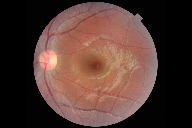

In [6]:
# view an image of 'healthy' retina
normal_img = image.load_img('archive/Training_Set/Training_Set/Training/10.png',target_size=(128,192,3))
print('normal image')
normal_img

diabetic retinopathy image


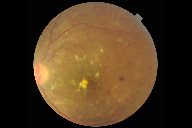

In [7]:
# view an image of 'healthy' retina
dr_img = image.load_img('archive/Training_Set/Training_Set/Training/1.png',target_size=(128,192,3))
print('diabetic retinopathy image')
dr_img

<b>'The image is labeled as DR if it shows any of the following clinical findings: microaneurysms, retinal dot and blot hemorrhage, hard exudates or cotton wool spots' **(see Figure 2a) [17]</b>

media haze image


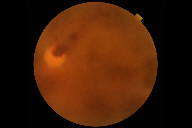

In [8]:
# view an image of 'healthy' retina
mh_img = image.load_img('archive/Training_Set/Training_Set/Training/780.png',target_size=(128,192,3))
print('media haze image')
mh_img

<b>'The opacity of media can be a hallmark for the presence of cataracts' **.</b>

<b>Reference(s):
** Pachade, S.; Porwal, P.; Thulkar, D.; Kokare, M.; Deshmukh, G.; Sahasrabuddhe, V.; Giancardo, L.; Quellec, G.;         Mériaudeau, F. Retinal Fundus Multi-Disease Image Dataset (RFMiD): A Dataset for Multi-Disease Detection Research.     Data 2021, 6, 14. https://doi.org/10.3390/data6020014</b>

# Neural Network models:

## Building a baseline model and verifying the custom metrics:

In this section I will:
1. Create a multi-layer perceptron as a baseline model
2. Use this model to comnfirm that the custom metrics work as they are supposed to

### Building a multi-layer perceptron as a baseline model

In [190]:
tf.random.set_seed(seed)
# Build a baseline fully connected model
from keras import models
from keras import layers

baseline_model = models.Sequential()
baseline_model.add(layers.Dense(64, activation='relu', input_shape=(49152,))) 
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(16, activation='relu'))
baseline_model.add(layers.Dense(3, activation='sigmoid'))
baseline_model.compile(optimizer='sgd',
              loss= 'binary_crossentropy',
              metrics= [recall_macro,acc_macro]
          )

In [31]:
results_baseline =  baseline_model.fit(train_img_unrow_dataset,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_img_unrow_dataset,val_labels))

Epoch 1/75
120/120 - 1s - loss: 0.5003 - recall_macro: 0.3581 - acc_macro: 0.7922 - val_loss: 0.4651 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 1s - loss: 0.4588 - recall_macro: 0.3378 - acc_macro: 0.8115 - val_loss: 0.4476 - val_recall_macro: 0.3294 - val_acc_macro: 0.8141
Epoch 3/75
120/120 - 1s - loss: 0.4409 - recall_macro: 0.3477 - acc_macro: 0.8123 - val_loss: 0.4402 - val_recall_macro: 0.3517 - val_acc_macro: 0.8141
Epoch 4/75
120/120 - 1s - loss: 0.4265 - recall_macro: 0.3886 - acc_macro: 0.8238 - val_loss: 0.4302 - val_recall_macro: 0.3093 - val_acc_macro: 0.8161
Epoch 5/75
120/120 - 1s - loss: 0.4145 - recall_macro: 0.4235 - acc_macro: 0.8302 - val_loss: 0.4170 - val_recall_macro: 0.3371 - val_acc_macro: 0.8240
Epoch 6/75
120/120 - 1s - loss: 0.4069 - recall_macro: 0.4535 - acc_macro: 0.8321 - val_loss: 0.4096 - val_recall_macro: 0.3947 - val_acc_macro: 0.8313
Epoch 7/75
120/120 - 1s - loss: 0.4069 - recall_macro: 0.4745 - acc_macro: 0.8309 - val_

Epoch 55/75
120/120 - 1s - loss: 0.3403 - recall_macro: 0.5920 - acc_macro: 0.8594 - val_loss: 0.3727 - val_recall_macro: 0.4344 - val_acc_macro: 0.8391
Epoch 56/75
120/120 - 1s - loss: 0.3375 - recall_macro: 0.6055 - acc_macro: 0.8620 - val_loss: 0.3940 - val_recall_macro: 0.4694 - val_acc_macro: 0.8297
Epoch 57/75
120/120 - 1s - loss: 0.3369 - recall_macro: 0.6080 - acc_macro: 0.8615 - val_loss: 0.3982 - val_recall_macro: 0.3650 - val_acc_macro: 0.8349
Epoch 58/75
120/120 - 1s - loss: 0.3428 - recall_macro: 0.5897 - acc_macro: 0.8552 - val_loss: 0.3802 - val_recall_macro: 0.3811 - val_acc_macro: 0.8380
Epoch 59/75
120/120 - 1s - loss: 0.3378 - recall_macro: 0.5954 - acc_macro: 0.8568 - val_loss: 0.3732 - val_recall_macro: 0.4704 - val_acc_macro: 0.8365
Epoch 60/75
120/120 - 1s - loss: 0.3327 - recall_macro: 0.6207 - acc_macro: 0.8641 - val_loss: 0.3670 - val_recall_macro: 0.4559 - val_acc_macro: 0.8432
Epoch 61/75
120/120 - 1s - loss: 0.3365 - recall_macro: 0.5885 - acc_macro: 0.8583

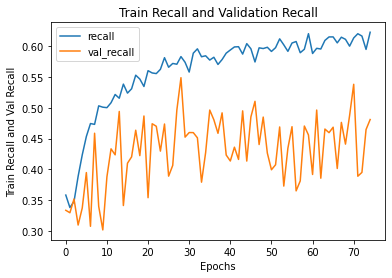

In [32]:
visualize_training_results(results_baseline)

In [33]:
baseline_train_eval_dict = baseline_model.evaluate(train_img_unrow_dataset, train_labels, return_dict=1, verbose=0)
recall_dict(baseline_train_eval_dict)

{'recall_macro': 0.6611, 'acc_macro': 0.8469}

In [34]:
baseline_val_eval_dict = baseline_model.evaluate(val_img_unrow_dataset, val_labels,return_dict=1, verbose=0)
recall_dict(baseline_val_eval_dict)

{'recall_macro': 0.5055, 'acc_macro': 0.837}

In [35]:
baseline_test_eval_dict = baseline_model.evaluate(test_img_unrow_dataset, test_labels,return_dict=1, verbose=0)
recall_dict(baseline_test_eval_dict)

{'recall_macro': 0.5189, 'acc_macro': 0.8682}

<b>Going forward, I will use these as my 'baseline' scores.</b>

### Verifying Custom Metrics

In this section:

1. The custom metric acc_macro should return the average of the indvidual accuracy scores of each of the three classes. I will use training data predictions to confirm that the custom metric works as expected.

2. The custom metric recall_macro should return the average of the indvidual recall scores of each of the three classes I will use training data predictions to confirm that the custom metric recall_macro works as expected

<b>Verifying acc_macro:</b>

In [36]:
# creating numpy array of training set predictions
b_line_train_preds = baseline_model.predict(train_img_unrow_dataset)
b_line_train_preds = np.round(b_line_train_preds)
# making sure that both 'b_line_train_preds' and 'b_line_train_labels' are type float
b_line_train_preds_II = b_line_train_preds.astype(float)
train_labels_II = train_labels.astype(float)

# didviding both the 'train_preds' and 'train_labels' arrays into three parts. One for each class.
b_line_train_preds_II_0 = b_line_train_preds_II[:,0]
train_labels_II_0 = train_labels_II[:,0]

b_line_train_preds_II_1 = b_line_train_preds_II[:,1]
train_labels_II_1 = train_labels_II[:,1]

b_line_train_preds_II_2 = b_line_train_preds_II[:,2]
train_labels_II_2 = train_labels_II[:,2]

In [37]:
# Using the Keras 'Accuracy' metric to calculate the acuracy for each respective class.

# Keras accuracy for class 0:
m = tf.keras.metrics.Accuracy()
m.update_state(train_labels_II_0, b_line_train_preds_II_0)
accuracy_score_class_0 = m.result().numpy()

# Keras accuracy for class 1:
m = tf.keras.metrics.Accuracy()
m.update_state(train_labels_II_1, b_line_train_preds_II_1)
accuracy_score_class_1 = m.result().numpy()

# Keras accuracy for class 2:
m = tf.keras.metrics.Accuracy()
m.update_state(train_labels_II_2, b_line_train_preds_II_2)
accuracy_score_class_2 = m.result().numpy()

# 'accuracy_macro' is the average of the three Keras 'Accuracy' scores:
accuracy_macro = (accuracy_score_class_0 + accuracy_score_class_1 + accuracy_score_class_2)/3



# Using the custom metric 'acc' to calculate the acuracy for each respective class:

acc_score_class_0 = acc(train_labels_II_0, b_line_train_preds_II_0).numpy()
acc_score_class_1 = acc(train_labels_II_1, b_line_train_preds_II_1).numpy()
acc_score_class_2 = acc(train_labels_II_2, b_line_train_preds_II_2).numpy()

# 'acc_macro_score' is the average of the three 'acc' scores using the custom metric 'acc_macro':
acc_macro_score = acc_macro(train_labels_II, b_line_train_preds_II).numpy()

print('Results using the Keras "Accuracy" metric:')
print('accuracy_score_class_0:', accuracy_score_class_0)
print('accuracy_score_class_1:', accuracy_score_class_1)
print('accuracy_score_class_2:', accuracy_score_class_2)
print('accuracy_macro score: ',  accuracy_macro,'\n\n')

print('Results using the custom "acc", and "acc_macro" metric:')
print('acc_score_class_0:', acc_score_class_0)
print('acc_score_class_1:', acc_score_class_1)
print('acc_score_class_2:', acc_score_class_2)
print('acc_macro_score: ',  acc_macro_score)

Results using the Keras "Accuracy" metric:
accuracy_score_class_0: 0.85260415
accuracy_score_class_1: 0.865625
accuracy_score_class_2: 0.82239586
accuracy_macro score:  0.8468750317891439 


Results using the custom "acc", and "acc_macro" metric:
acc_score_class_0: 0.8526041666666667
acc_score_class_1: 0.865625
acc_score_class_2: 0.8223958333333333
acc_macro_score:  0.8468749999999999


<b>The results are identical to five decimal points or more</b>

<b>Verifying recall_macro:</b>

In [38]:
# producing sklearn's classification report to view their recall macro avg:
class_report = (classification_report(train_labels_II, b_line_train_preds_II))

# the macro average of the recall scores of each respective class, returned by the custom metric "recall_macro":
recall_macro_score = np.round(recall_macro(train_labels_II, b_line_train_preds_II).numpy(),2)

print("sklearn's classification report:\n\n",class_report)
print('recall_macro_score: ',recall_macro_score)

sklearn's classification report:

               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1519
           1       0.83      0.40      0.54       376
           2       0.47      0.72      0.57       317

   micro avg       0.78      0.84      0.81      2212
   macro avg       0.72      0.70      0.67      2212
weighted avg       0.80      0.84      0.80      2212
 samples avg       0.70      0.69      0.68      2212

recall_macro_score:  0.7


<b>The macro avaerage of the recall score produced by the classification report, and the result returned by the custom metric "recall_macro" are identical.</b> 

 ## Build a CNN 

1. I will try to overfit while also checking to see if that rise in the training score had any impact on the validation score.<br><br>
2. From there, when I am satisfied with the model architecture(number of layers, and number of nodes per layer), I  will try to reduce the variance by using different combinations of filter sizes, with the goal of making the model more generalizable.<br><br>
3. Once I am satisifed with the filters, I would apply an optimizer with different learning rates, to see if this would improve results, or give me additional information about where the line plots for the scores of the respective data sets stop oscillating, and possibly reach their respective convergences'.<br><br>
4. After this, I would choose the best model amongst these and try to further reduce the variance by using some regularization technique, such as adding a dropout layer(s), or using L1, or L2 regularization, or poassiblly combining techniques. 

## CNN-1 through CNN-5: Try to overfit

 ### CNN-1

<b>The goal in the first few models is to get as high a training score as possible, while also looking at how this impacts the validation score. I have my baseline scores as:

training :   0.6611<br>
validation:  0.5189</b>

In [39]:
tf.random.set_seed(seed)

cnn_model_1 = models.Sequential()
cnn_model_1.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_1.add(layers.MaxPooling2D((2, 2)))

cnn_model_1.add(layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model_1.add(layers.MaxPooling2D((2, 2)))

cnn_model_1.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model_1.add(layers.MaxPooling2D((2, 2)))

cnn_model_1.add(layers.Conv2D(128, (2, 2), activation='relu'))
cnn_model_1.add(layers.MaxPooling2D((2, 2)))

cnn_model_1.add(layers.Flatten())
cnn_model_1.add(layers.Dense(32, activation='relu'))
cnn_model_1.add(layers.Dense(3, activation='sigmoid'))

cnn_model_1.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [40]:
results_cnn1 = cnn_model_1.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 7s - loss: 0.5423 - recall_macro: 0.3303 - acc_macro: 0.7997 - val_loss: 0.4835 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 6s - loss: 0.4823 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4818 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 6s - loss: 0.4810 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4806 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 6s - loss: 0.4793 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4780 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 6s - loss: 0.4774 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4769 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 6s - loss: 0.4750 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4750 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 6s - loss: 0.4730 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 5s - loss: 0.3533 - recall_macro: 0.5707 - acc_macro: 0.8500 - val_loss: 0.3736 - val_recall_macro: 0.4453 - val_acc_macro: 0.8385
Epoch 56/75
120/120 - 5s - loss: 0.3524 - recall_macro: 0.5756 - acc_macro: 0.8467 - val_loss: 0.3737 - val_recall_macro: 0.4868 - val_acc_macro: 0.8396
Epoch 57/75
120/120 - 5s - loss: 0.3503 - recall_macro: 0.5781 - acc_macro: 0.8531 - val_loss: 0.3895 - val_recall_macro: 0.3908 - val_acc_macro: 0.8401
Epoch 58/75
120/120 - 5s - loss: 0.3538 - recall_macro: 0.5858 - acc_macro: 0.8500 - val_loss: 0.3921 - val_recall_macro: 0.3661 - val_acc_macro: 0.8328
Epoch 59/75
120/120 - 5s - loss: 0.3499 - recall_macro: 0.5714 - acc_macro: 0.8497 - val_loss: 0.3670 - val_recall_macro: 0.4984 - val_acc_macro: 0.8422
Epoch 60/75
120/120 - 5s - loss: 0.3454 - recall_macro: 0.6165 - acc_macro: 0.8578 - val_loss: 0.3655 - val_recall_macro: 0.4682 - val_acc_macro: 0.8396
Epoch 61/75
120/120 - 5s - loss: 0.3467 - recall_macro: 0.5843 - acc_macro: 0.8531

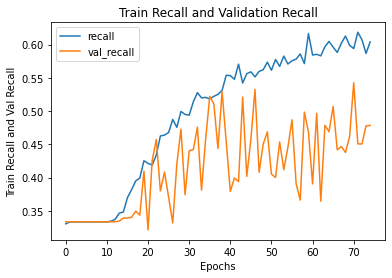

In [41]:
visualize_training_results(results_cnn1)

In [42]:
cnn_1_train_eval_dict = cnn_model_1.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_1_train_eval_dict)

{'recall_macro': 0.6471, 'acc_macro': 0.8519}

In [43]:
cnn_1_val_eval_dict = cnn_model_1.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_1_val_eval_dict)

{'recall_macro': 0.5106, 'acc_macro': 0.8401}

In [44]:
cnn_1_test_eval_dict = cnn_model_1.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_1_test_eval_dict)

{'recall_macro': 0.5206, 'acc_macro': 0.8568}

<b>The initial CNN traing score was slightly lower than that of the baseline model, but the validation score is higher, which is a good thing.</b>

 ### CNN-2

<b>I will double the number of nodes in the input layer of the CNN-1 model, to see if I could raise the training score:</b>

In [45]:
tf.random.set_seed(seed)

cnn_model_2 = models.Sequential()
cnn_model_2.add(layers.Conv2D(32, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(128, (2, 2), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(32, activation='relu'))
cnn_model_2.add(layers.Dense(3, activation='sigmoid'))

cnn_model_2.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [46]:
results_cnn2 = cnn_model_2.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 9s - loss: 0.5739 - recall_macro: 0.3274 - acc_macro: 0.8050 - val_loss: 0.4864 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 8s - loss: 0.4826 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4821 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 8s - loss: 0.4819 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4823 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 9s - loss: 0.4811 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4807 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 9s - loss: 0.4802 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4800 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 9s - loss: 0.4791 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4793 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 9s - loss: 0.4783 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 9s - loss: 0.3679 - recall_macro: 0.5432 - acc_macro: 0.8438 - val_loss: 0.3870 - val_recall_macro: 0.4132 - val_acc_macro: 0.8328
Epoch 56/75
120/120 - 9s - loss: 0.3677 - recall_macro: 0.5341 - acc_macro: 0.8403 - val_loss: 0.3950 - val_recall_macro: 0.4765 - val_acc_macro: 0.8385
Epoch 57/75
120/120 - 9s - loss: 0.3654 - recall_macro: 0.5460 - acc_macro: 0.8429 - val_loss: 0.4004 - val_recall_macro: 0.3817 - val_acc_macro: 0.8359
Epoch 58/75
120/120 - 9s - loss: 0.3690 - recall_macro: 0.5572 - acc_macro: 0.8439 - val_loss: 0.4023 - val_recall_macro: 0.3490 - val_acc_macro: 0.8266
Epoch 59/75
120/120 - 9s - loss: 0.3660 - recall_macro: 0.5420 - acc_macro: 0.8441 - val_loss: 0.3821 - val_recall_macro: 0.4729 - val_acc_macro: 0.8422
Epoch 60/75
120/120 - 9s - loss: 0.3609 - recall_macro: 0.5722 - acc_macro: 0.8502 - val_loss: 0.3809 - val_recall_macro: 0.4552 - val_acc_macro: 0.8411
Epoch 61/75
120/120 - 9s - loss: 0.3632 - recall_macro: 0.5504 - acc_macro: 0.8448

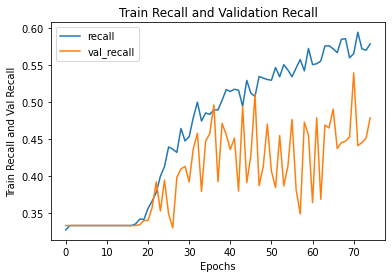

In [47]:
visualize_training_results(results_cnn2)

In [48]:
cnn_2_train_eval_dict = cnn_model_2.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_2_train_eval_dict)

{'recall_macro': 0.6203, 'acc_macro': 0.8497}

In [49]:
cnn_2_val_eval_dict = cnn_model_2.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_2_val_eval_dict)

{'recall_macro': 0.5001, 'acc_macro': 0.8411}

In [50]:
cnn_2_test_eval_dict = cnn_model_2.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_2_test_eval_dict)

{'recall_macro': 0.5135, 'acc_macro': 0.8583}

<b>Both the traing and validation scores have gone down.</b> 

 ### CNN-3

<b>Given that the score actually went down with CNN-2, I will keep the architecture the same as CNN-1, but add an 8 node layer to the beginning of the model(input layer):</b>

In [51]:
tf.random.set_seed(seed)

cnn_model_3 = models.Sequential()
cnn_model_3.add(layers.Conv2D(8, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(16, (2, 2), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(128, (2, 2), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Flatten())
cnn_model_3.add(layers.Dense(32, activation='relu'))
cnn_model_3.add(layers.Dense(3, activation='sigmoid'))

cnn_model_3.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [52]:
results_cnn3 = cnn_model_3.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 4s - loss: 0.5684 - recall_macro: 0.3978 - acc_macro: 0.7651 - val_loss: 0.4936 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 3s - loss: 0.4846 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4809 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 4s - loss: 0.4811 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4814 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 3s - loss: 0.4803 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4798 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 3s - loss: 0.4796 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4794 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 4s - loss: 0.4785 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4784 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 3s - loss: 0.4780 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 3s - loss: 0.3789 - recall_macro: 0.5139 - acc_macro: 0.8361 - val_loss: 0.4079 - val_recall_macro: 0.3743 - val_acc_macro: 0.8245
Epoch 56/75
120/120 - 3s - loss: 0.3783 - recall_macro: 0.5189 - acc_macro: 0.8370 - val_loss: 0.4160 - val_recall_macro: 0.4859 - val_acc_macro: 0.8276
Epoch 57/75
120/120 - 4s - loss: 0.3767 - recall_macro: 0.5296 - acc_macro: 0.8401 - val_loss: 0.4067 - val_recall_macro: 0.3797 - val_acc_macro: 0.8313
Epoch 58/75
120/120 - 3s - loss: 0.3790 - recall_macro: 0.5251 - acc_macro: 0.8380 - val_loss: 0.4079 - val_recall_macro: 0.3691 - val_acc_macro: 0.8286
Epoch 59/75
120/120 - 3s - loss: 0.3760 - recall_macro: 0.5303 - acc_macro: 0.8422 - val_loss: 0.3957 - val_recall_macro: 0.4160 - val_acc_macro: 0.8344
Epoch 60/75
120/120 - 3s - loss: 0.3713 - recall_macro: 0.5545 - acc_macro: 0.8460 - val_loss: 0.3953 - val_recall_macro: 0.4314 - val_acc_macro: 0.8344
Epoch 61/75
120/120 - 3s - loss: 0.3743 - recall_macro: 0.5264 - acc_macro: 0.8417

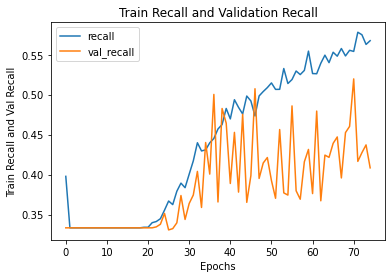

In [53]:
visualize_training_results(results_cnn3)

In [54]:
cnn_3_train_eval_dict = cnn_model_3.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_3_train_eval_dict)

{'recall_macro': 0.5829, 'acc_macro': 0.8441}

In [55]:
cnn_3_val_eval_dict = cnn_model_3.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_3_val_eval_dict)

{'recall_macro': 0.4144, 'acc_macro': 0.8286}

In [56]:
cnn_3_test_eval_dict = cnn_model_3.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_3_test_eval_dict)

{'recall_macro': 0.475, 'acc_macro': 0.8526}

<b>Both the training and validation scores are considerably lower than CNN-1.</b>

 ### CNN-4

<b>I will keep the same architecture as CNN-1 but add padding, so that the model can potentially gain more information about the respective edges at each layer:</b>

In [57]:
tf.random.set_seed(seed)

cnn_model_4 = models.Sequential()
cnn_model_4.add(layers.Conv2D(16, (2, 2),padding='same',activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(32, (2, 2),padding='same', activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(64, (2, 2),padding='same', activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(128, (2, 2),padding='same', activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Flatten())
cnn_model_4.add(layers.Dense(32, activation='relu'))
cnn_model_4.add(layers.Dense(3, activation='sigmoid'))

cnn_model_4.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [58]:
results_cnn4 = cnn_model_4.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 6s - loss: 0.5375 - recall_macro: 0.3361 - acc_macro: 0.8042 - val_loss: 0.4827 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 6s - loss: 0.4812 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4808 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 6s - loss: 0.4797 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4799 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 6s - loss: 0.4779 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4774 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 6s - loss: 0.4755 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4757 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 6s - loss: 0.4726 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4734 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 6s - loss: 0.4698 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 6s - loss: 0.3520 - recall_macro: 0.5764 - acc_macro: 0.8514 - val_loss: 0.3733 - val_recall_macro: 0.4408 - val_acc_macro: 0.8391
Epoch 56/75
120/120 - 6s - loss: 0.3512 - recall_macro: 0.5801 - acc_macro: 0.8483 - val_loss: 0.3746 - val_recall_macro: 0.4849 - val_acc_macro: 0.8417
Epoch 57/75
120/120 - 6s - loss: 0.3499 - recall_macro: 0.5748 - acc_macro: 0.8516 - val_loss: 0.3935 - val_recall_macro: 0.3831 - val_acc_macro: 0.8359
Epoch 58/75
120/120 - 6s - loss: 0.3531 - recall_macro: 0.5792 - acc_macro: 0.8523 - val_loss: 0.3952 - val_recall_macro: 0.3535 - val_acc_macro: 0.8333
Epoch 59/75
120/120 - 6s - loss: 0.3500 - recall_macro: 0.5831 - acc_macro: 0.8536 - val_loss: 0.3680 - val_recall_macro: 0.5128 - val_acc_macro: 0.8453
Epoch 60/75
120/120 - 6s - loss: 0.3448 - recall_macro: 0.6059 - acc_macro: 0.8573 - val_loss: 0.3657 - val_recall_macro: 0.4568 - val_acc_macro: 0.8401
Epoch 61/75
120/120 - 6s - loss: 0.3471 - recall_macro: 0.5722 - acc_macro: 0.8507

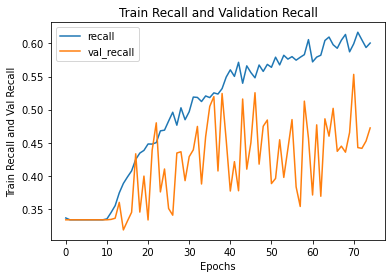

In [59]:
visualize_training_results(results_cnn4)

In [60]:
cnn_4_train_eval_dict = cnn_model_4.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_4_train_eval_dict)

{'recall_macro': 0.6566, 'acc_macro': 0.8549}

In [61]:
cnn_4_val_eval_dict = cnn_model_4.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_4_val_eval_dict)

{'recall_macro': 0.5031, 'acc_macro': 0.8406}

In [62]:
cnn_4_test_eval_dict = cnn_model_4.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_4_test_eval_dict)

{'recall_macro': 0.5194, 'acc_macro': 0.8562}

<b>The padding slightly increased the training score, but lowered the test score (relative to CNN-1), thereby increasing variance. For this reason, moving forward, I will not use the padding.</b> 

 ### CNN-5

<b>I will modify CNN-1 by removing the last pooling layer, so that the classification portion of the model has more data to work with.</b> 

In [63]:
tf.random.set_seed(seed)

cnn_model_5 = models.Sequential()
cnn_model_5.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(64, (2, 2), activation='relu'))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(128, (2, 2), activation='relu'))

cnn_model_5.add(layers.Flatten())
cnn_model_5.add(layers.Dense(32, activation='relu'))
cnn_model_5.add(layers.Dense(3, activation='sigmoid'))

cnn_model_5.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [64]:
results_cnn5 = cnn_model_5.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 6s - loss: 0.5113 - recall_macro: 0.3342 - acc_macro: 0.8038 - val_loss: 0.4821 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 6s - loss: 0.4796 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4790 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 6s - loss: 0.4762 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4752 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 6s - loss: 0.4721 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4700 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 6s - loss: 0.4670 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4663 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 6s - loss: 0.4600 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4621 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 6s - loss: 0.4547 - recall_macro: 0.3343 - acc_macro: 0.8102 - val_

Epoch 55/75
120/120 - 6s - loss: 0.3330 - recall_macro: 0.6087 - acc_macro: 0.8578 - val_loss: 0.3589 - val_recall_macro: 0.4625 - val_acc_macro: 0.8417
Epoch 56/75
120/120 - 6s - loss: 0.3318 - recall_macro: 0.6108 - acc_macro: 0.8569 - val_loss: 0.3623 - val_recall_macro: 0.4454 - val_acc_macro: 0.8396
Epoch 57/75
120/120 - 6s - loss: 0.3296 - recall_macro: 0.6110 - acc_macro: 0.8613 - val_loss: 0.3786 - val_recall_macro: 0.3861 - val_acc_macro: 0.8365
Epoch 58/75
120/120 - 6s - loss: 0.3325 - recall_macro: 0.6033 - acc_macro: 0.8590 - val_loss: 0.3796 - val_recall_macro: 0.3870 - val_acc_macro: 0.8359
Epoch 59/75
120/120 - 6s - loss: 0.3290 - recall_macro: 0.6134 - acc_macro: 0.8580 - val_loss: 0.3534 - val_recall_macro: 0.4955 - val_acc_macro: 0.8464
Epoch 60/75
120/120 - 6s - loss: 0.3241 - recall_macro: 0.6455 - acc_macro: 0.8653 - val_loss: 0.3540 - val_recall_macro: 0.4758 - val_acc_macro: 0.8490
Epoch 61/75
120/120 - 6s - loss: 0.3260 - recall_macro: 0.5977 - acc_macro: 0.8611

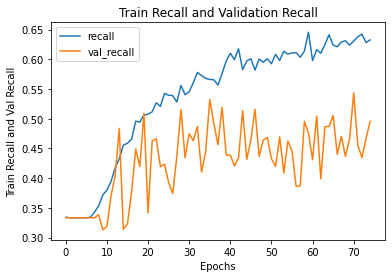

In [65]:
visualize_training_results(results_cnn5)

In [66]:
cnn_5_train_eval_dict = cnn_model_5.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_5_train_eval_dict)

{'recall_macro': 0.6859, 'acc_macro': 0.8571}

In [67]:
cnn_5_val_eval_dict = cnn_model_5.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_5_val_eval_dict)

{'recall_macro': 0.5405, 'acc_macro': 0.8474}

In [68]:
cnn_5_test_eval_dict = cnn_model_5.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_5_test_eval_dict)

{'recall_macro': 0.5389, 'acc_macro': 0.8609}

<b>Both scores have gone up. The train score has increased by almost four points, and the test score by close to three points. I feel this is a considerable increase in the test score, and that the possible increase in variance could be reconciled. For that reason, moving forward I will use this architecture.</b>

## CNN-6 through CNN-9: Try different filter sizes:

 ### CNN-6

<b>I will use the same architetcture as in CNN-5, but add 3x3 filters on the last two activation layers to try to make the model more generalizeable, thereby reducing variance.</b>

In [69]:
tf.random.set_seed(seed)

cnn_model_6 = models.Sequential()
cnn_model_6.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))


cnn_model_6.add(layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))

cnn_model_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))

cnn_model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))

cnn_model_6.add(layers.Flatten())
cnn_model_6.add(layers.Dense(32, activation='relu'))
cnn_model_6.add(layers.Dense(3, activation='sigmoid'))

cnn_model_6.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [70]:
results_cnn6 = cnn_model_6.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 6s - loss: 0.5109 - recall_macro: 0.3361 - acc_macro: 0.8017 - val_loss: 0.4829 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 6s - loss: 0.4815 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4795 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 6s - loss: 0.4794 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4775 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 6s - loss: 0.4761 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4734 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 6s - loss: 0.4714 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4693 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 6s - loss: 0.4653 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4677 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 6s - loss: 0.4601 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 6s - loss: 0.3340 - recall_macro: 0.6093 - acc_macro: 0.8573 - val_loss: 0.3662 - val_recall_macro: 0.4511 - val_acc_macro: 0.8406
Epoch 56/75
120/120 - 6s - loss: 0.3324 - recall_macro: 0.6112 - acc_macro: 0.8564 - val_loss: 0.3675 - val_recall_macro: 0.4621 - val_acc_macro: 0.8380
Epoch 57/75
120/120 - 6s - loss: 0.3306 - recall_macro: 0.6101 - acc_macro: 0.8597 - val_loss: 0.3806 - val_recall_macro: 0.3989 - val_acc_macro: 0.8359
Epoch 58/75
120/120 - 6s - loss: 0.3332 - recall_macro: 0.6070 - acc_macro: 0.8578 - val_loss: 0.3895 - val_recall_macro: 0.3831 - val_acc_macro: 0.8359
Epoch 59/75
120/120 - 6s - loss: 0.3303 - recall_macro: 0.6181 - acc_macro: 0.8620 - val_loss: 0.3585 - val_recall_macro: 0.4907 - val_acc_macro: 0.8422
Epoch 60/75
120/120 - 6s - loss: 0.3238 - recall_macro: 0.6437 - acc_macro: 0.8656 - val_loss: 0.3587 - val_recall_macro: 0.4832 - val_acc_macro: 0.8432
Epoch 61/75
120/120 - 7s - loss: 0.3261 - recall_macro: 0.6019 - acc_macro: 0.8604

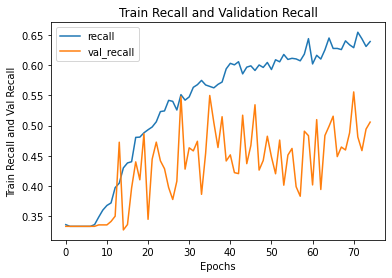

In [71]:
visualize_training_results(results_cnn6)

In [72]:
cnn_6_train_eval_dict = cnn_model_6.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_6_train_eval_dict)

{'recall_macro': 0.6868, 'acc_macro': 0.8686}

In [73]:
cnn_6_val_eval_dict = cnn_model_6.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_6_val_eval_dict)

{'recall_macro': 0.5386, 'acc_macro': 0.8427}

In [74]:
cnn_6_test_eval_dict = cnn_model_6.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_6_test_eval_dict)

{'recall_macro': 0.5321, 'acc_macro': 0.8578}

<b>Relative to CNN-5 the training score went up, but the test score went down, increasing variance.</b> 

 ### CNN-7

<b>I will use the same architetcture as in CNN-5, but will use a 3x3 filter, and a 5x5 filter on the last two activation layers respectively, to try to make the model more generalizeable, thereby reducing variance.</b>

In [75]:
tf.random.set_seed(seed)

cnn_model_7 = models.Sequential()
cnn_model_7.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))


cnn_model_7.add(layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))

cnn_model_7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))

cnn_model_7.add(layers.Conv2D(128, (5, 5), activation='relu'))

cnn_model_7.add(layers.Flatten())
cnn_model_7.add(layers.Dense(32, activation='relu'))
cnn_model_7.add(layers.Dense(3, activation='sigmoid'))

cnn_model_7.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [76]:
results_cnn7 = cnn_model_7.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 7s - loss: 0.5265 - recall_macro: 0.3333 - acc_macro: 0.8066 - val_loss: 0.4820 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 7s - loss: 0.4831 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4811 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 7s - loss: 0.4827 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4811 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 7s - loss: 0.4817 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4791 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 6s - loss: 0.4804 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4777 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 6s - loss: 0.4776 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4764 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 7s - loss: 0.4755 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 6s - loss: 0.3384 - recall_macro: 0.6146 - acc_macro: 0.8582 - val_loss: 0.3722 - val_recall_macro: 0.4409 - val_acc_macro: 0.8391
Epoch 56/75
120/120 - 7s - loss: 0.3367 - recall_macro: 0.6118 - acc_macro: 0.8545 - val_loss: 0.3680 - val_recall_macro: 0.4554 - val_acc_macro: 0.8401
Epoch 57/75
120/120 - 6s - loss: 0.3347 - recall_macro: 0.6027 - acc_macro: 0.8601 - val_loss: 0.3825 - val_recall_macro: 0.3988 - val_acc_macro: 0.8365
Epoch 58/75
120/120 - 6s - loss: 0.3375 - recall_macro: 0.6067 - acc_macro: 0.8556 - val_loss: 0.3888 - val_recall_macro: 0.3860 - val_acc_macro: 0.8339
Epoch 59/75
120/120 - 6s - loss: 0.3340 - recall_macro: 0.6121 - acc_macro: 0.8582 - val_loss: 0.3591 - val_recall_macro: 0.4850 - val_acc_macro: 0.8417
Epoch 60/75
120/120 - 6s - loss: 0.3277 - recall_macro: 0.6374 - acc_macro: 0.8641 - val_loss: 0.3587 - val_recall_macro: 0.4851 - val_acc_macro: 0.8453
Epoch 61/75
120/120 - 6s - loss: 0.3297 - recall_macro: 0.5969 - acc_macro: 0.8563

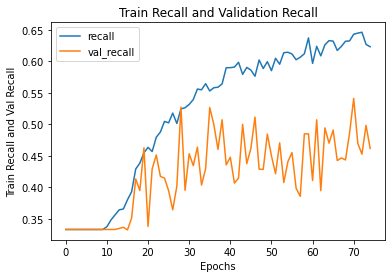

In [77]:
visualize_training_results(results_cnn7)

In [78]:
cnn_7_train_eval_dict = cnn_model_7.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_7_train_eval_dict)

{'recall_macro': 0.6573, 'acc_macro': 0.8736}

In [79]:
cnn_7_val_eval_dict = cnn_model_7.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_7_val_eval_dict)

{'recall_macro': 0.4917, 'acc_macro': 0.8417}

In [80]:
cnn_7_test_eval_dict = cnn_model_7.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_7_test_eval_dict)

{'recall_macro': 0.5123, 'acc_macro': 0.8625}

<b>Both the training and test scores are lower than CNN-5, but the difference between the train and the test scores is virtually identical. For that reason, I will continue with the CNN-5 architecture going forward.</b>

 ### CNN-8

<b>I will use the same architetcture as in CNN-5, but will use a 3x3, 3x3, and 5x5 filter on the last three layers respectively,to try to make the model more generalizeable, thereby reducing variance.</b>

In [81]:
tf.random.set_seed(seed)

cnn_model_8 = models.Sequential()
cnn_model_8.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_8.add(layers.MaxPooling2D((2, 2)))

cnn_model_8.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_8.add(layers.MaxPooling2D((2, 2)))

cnn_model_8.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_8.add(layers.MaxPooling2D((2, 2)))

cnn_model_8.add(layers.Conv2D(128, (5, 5), activation='relu'))

cnn_model_8.add(layers.Flatten())
cnn_model_8.add(layers.Dense(32, activation='relu'))
cnn_model_8.add(layers.Dense(3, activation='sigmoid'))


cnn_model_8.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [82]:
results_cnn8 = cnn_model_8.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 8s - loss: 0.5225 - recall_macro: 0.3361 - acc_macro: 0.8036 - val_loss: 0.4830 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 7s - loss: 0.4831 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4815 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 7s - loss: 0.4822 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4802 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 7s - loss: 0.4807 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4784 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 7s - loss: 0.4783 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4758 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 7s - loss: 0.4749 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4751 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 8s - loss: 0.4715 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 7s - loss: 0.3404 - recall_macro: 0.5860 - acc_macro: 0.8538 - val_loss: 0.3723 - val_recall_macro: 0.4386 - val_acc_macro: 0.8391
Epoch 56/75
120/120 - 7s - loss: 0.3376 - recall_macro: 0.6043 - acc_macro: 0.8571 - val_loss: 0.3675 - val_recall_macro: 0.4805 - val_acc_macro: 0.8443
Epoch 57/75
120/120 - 7s - loss: 0.3354 - recall_macro: 0.5927 - acc_macro: 0.8585 - val_loss: 0.3828 - val_recall_macro: 0.4099 - val_acc_macro: 0.8391
Epoch 58/75
120/120 - 7s - loss: 0.3382 - recall_macro: 0.6065 - acc_macro: 0.8576 - val_loss: 0.3952 - val_recall_macro: 0.3665 - val_acc_macro: 0.8339
Epoch 59/75
120/120 - 7s - loss: 0.3346 - recall_macro: 0.6131 - acc_macro: 0.8590 - val_loss: 0.3614 - val_recall_macro: 0.4866 - val_acc_macro: 0.8385
Epoch 60/75
120/120 - 7s - loss: 0.3277 - recall_macro: 0.6335 - acc_macro: 0.8646 - val_loss: 0.3610 - val_recall_macro: 0.4849 - val_acc_macro: 0.8464
Epoch 61/75
120/120 - 7s - loss: 0.3307 - recall_macro: 0.5954 - acc_macro: 0.8566

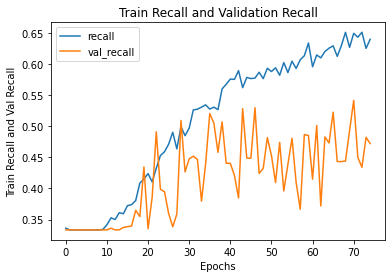

In [83]:
visualize_training_results(results_cnn8)

In [84]:
cnn_8_train_eval_dict = cnn_model_8.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_8_train_eval_dict)

{'recall_macro': 0.6653, 'acc_macro': 0.8774}

In [85]:
cnn_8_val_eval_dict = cnn_model_8.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_8_val_eval_dict)

{'recall_macro': 0.5046, 'acc_macro': 0.8448}

In [86]:
cnn_8_test_eval_dict = cnn_model_8.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_8_test_eval_dict)

{'recall_macro': 0.5361, 'acc_macro': 0.8656}

<b>These are the best scores yet. The training score is over two points less than CNN-5, yet the test score is only a quarter of a point less, thereby reducing the variance, while keeping the test score virtually the same. Going forward, these would be the scores to beat.</b>

### CNN-9

<b>I will use a 3x3, 3x3, 3x3, and 5x5 filter on the four layers respectively,to try to make the model more generalizeable, thereby reducing variance.</b>

In [87]:
tf.random.set_seed(seed)

cnn_model_9 = models.Sequential()
cnn_model_9.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(128 ,128,  3)))

cnn_model_9.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_9.add(layers.MaxPooling2D((2, 2)))

cnn_model_9.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_9.add(layers.MaxPooling2D((2, 2)))

cnn_model_9.add(layers.Conv2D(128, (5, 5), activation='relu'))

cnn_model_9.add(layers.Flatten())
cnn_model_9.add(layers.Dense(32, activation='relu'))
cnn_model_9.add(layers.Dense(3, activation='sigmoid'))

cnn_model_9.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [88]:
results_cnn9 = cnn_model_9.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 22s - loss: 0.5005 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4826 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 21s - loss: 0.4770 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4745 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 22s - loss: 0.4678 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4665 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 22s - loss: 0.4606 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4570 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 22s - loss: 0.4514 - recall_macro: 0.3437 - acc_macro: 0.8116 - val_loss: 0.4486 - val_recall_macro: 0.3350 - val_acc_macro: 0.8089
Epoch 6/75
120/120 - 22s - loss: 0.4440 - recall_macro: 0.3635 - acc_macro: 0.8139 - val_loss: 0.4450 - val_recall_macro: 0.3350 - val_acc_macro: 0.8089
Epoch 7/75
120/120 - 22s - loss: 0.4409 - recall_macro: 0.3845 - acc_macro: 0.8142

Epoch 55/75
120/120 - 22s - loss: 0.2786 - recall_macro: 0.6762 - acc_macro: 0.8811 - val_loss: 0.3718 - val_recall_macro: 0.4764 - val_acc_macro: 0.8406
Epoch 56/75
120/120 - 22s - loss: 0.2740 - recall_macro: 0.7065 - acc_macro: 0.8840 - val_loss: 0.3733 - val_recall_macro: 0.4784 - val_acc_macro: 0.8370
Epoch 57/75
120/120 - 22s - loss: 0.2706 - recall_macro: 0.7011 - acc_macro: 0.8837 - val_loss: 0.3744 - val_recall_macro: 0.4430 - val_acc_macro: 0.8349
Epoch 58/75
120/120 - 22s - loss: 0.2710 - recall_macro: 0.6950 - acc_macro: 0.8858 - val_loss: 0.3731 - val_recall_macro: 0.4788 - val_acc_macro: 0.8344
Epoch 59/75
120/120 - 22s - loss: 0.2657 - recall_macro: 0.7035 - acc_macro: 0.8878 - val_loss: 0.3645 - val_recall_macro: 0.5125 - val_acc_macro: 0.8365
Epoch 60/75
120/120 - 22s - loss: 0.2549 - recall_macro: 0.7337 - acc_macro: 0.8911 - val_loss: 0.3744 - val_recall_macro: 0.4988 - val_acc_macro: 0.8312
Epoch 61/75
120/120 - 22s - loss: 0.2584 - recall_macro: 0.7089 - acc_macro:

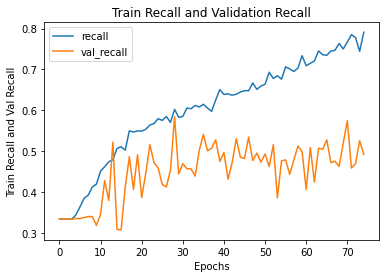

In [89]:
visualize_training_results(results_cnn9)

In [90]:
cnn_9_train_eval_dict = cnn_model_9.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_9_train_eval_dict)

{'recall_macro': 0.795, 'acc_macro': 0.9267}

In [91]:
cnn_9_val_eval_dict = cnn_model_9.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_9_val_eval_dict)

{'recall_macro': 0.5126, 'acc_macro': 0.8333}

In [92]:
cnn_9_test_eval_dict = cnn_model_9.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_9_test_eval_dict)

{'recall_macro': 0.5342, 'acc_macro': 0.8526}

<b>Interestingly enough this actually caused the training score to go up almost thirteen points, relative to CNN-8, but made the test score go down; making for a considerably worse variance. Going forward I will use the CNN-8 model architecture.</b>

## CNN-10 through CNN-11: Try different optimizers:

### CNN-10

<b>I will use the same architecture as in CNN-8, but will apply the Adam optimizer, using all its default settings, to 'speed up' the learning process, and see how the model would progress.</b>

In [93]:
tf.random.set_seed(seed)

cnn_model_10 = models.Sequential()
cnn_model_10.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_10.add(layers.MaxPooling2D((2, 2)))


cnn_model_10.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_10.add(layers.MaxPooling2D((2, 2)))

cnn_model_10.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_10.add(layers.MaxPooling2D((2, 2)))

cnn_model_10.add(layers.Conv2D(128, (5, 5),activation='relu'))

cnn_model_10.add(layers.Flatten())
cnn_model_10.add(layers.Dense(32, activation='relu'))
cnn_model_10.add(layers.Dense(3, activation='sigmoid'))


cnn_model_10.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=[recall_macro,acc_macro])

In [94]:
results_cnn10 = cnn_model_10.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 8s - loss: 0.4920 - recall_macro: 0.3442 - acc_macro: 0.8075 - val_loss: 0.4872 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 8s - loss: 0.4610 - recall_macro: 0.3687 - acc_macro: 0.8125 - val_loss: 0.4385 - val_recall_macro: 0.3406 - val_acc_macro: 0.8099
Epoch 3/75
120/120 - 8s - loss: 0.4323 - recall_macro: 0.4249 - acc_macro: 0.8200 - val_loss: 0.4102 - val_recall_macro: 0.4015 - val_acc_macro: 0.8344
Epoch 4/75
120/120 - 8s - loss: 0.4098 - recall_macro: 0.4876 - acc_macro: 0.8314 - val_loss: 0.4039 - val_recall_macro: 0.3794 - val_acc_macro: 0.8260
Epoch 5/75
120/120 - 8s - loss: 0.3923 - recall_macro: 0.5129 - acc_macro: 0.8375 - val_loss: 0.3953 - val_recall_macro: 0.4976 - val_acc_macro: 0.8401
Epoch 6/75
120/120 - 8s - loss: 0.3755 - recall_macro: 0.5711 - acc_macro: 0.8464 - val_loss: 0.3849 - val_recall_macro: 0.5432 - val_acc_macro: 0.8297
Epoch 7/75
120/120 - 8s - loss: 0.3679 - recall_macro: 0.6046 - acc_macro: 0.8481 - val_

Epoch 55/75
120/120 - 7s - loss: 0.0018 - recall_macro: 0.9653 - acc_macro: 0.9995 - val_loss: 1.5039 - val_recall_macro: 0.5077 - val_acc_macro: 0.8474
Epoch 56/75
120/120 - 8s - loss: 0.0016 - recall_macro: 0.9685 - acc_macro: 0.9997 - val_loss: 1.5490 - val_recall_macro: 0.5116 - val_acc_macro: 0.8453
Epoch 57/75
120/120 - 8s - loss: 0.0015 - recall_macro: 0.9743 - acc_macro: 0.9997 - val_loss: 1.5675 - val_recall_macro: 0.5072 - val_acc_macro: 0.8458
Epoch 58/75
120/120 - 8s - loss: 0.0013 - recall_macro: 0.9769 - acc_macro: 0.9997 - val_loss: 1.6097 - val_recall_macro: 0.5097 - val_acc_macro: 0.8453
Epoch 59/75
120/120 - 8s - loss: 0.0012 - recall_macro: 0.9713 - acc_macro: 0.9997 - val_loss: 1.6340 - val_recall_macro: 0.5129 - val_acc_macro: 0.8443
Epoch 60/75
120/120 - 8s - loss: 0.0011 - recall_macro: 0.9771 - acc_macro: 0.9997 - val_loss: 1.6828 - val_recall_macro: 0.5095 - val_acc_macro: 0.8464
Epoch 61/75
120/120 - 8s - loss: 0.0139 - recall_macro: 0.9599 - acc_macro: 0.9970

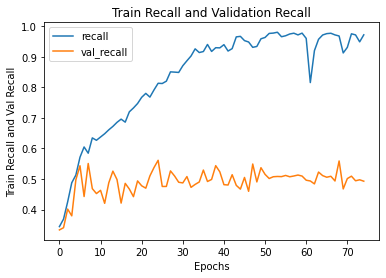

In [95]:
visualize_training_results(results_cnn10)

In [96]:
cnn_10_train_eval_dict = cnn_model_10.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_10_train_eval_dict)

{'recall_macro': 0.9605, 'acc_macro': 0.9997}

In [97]:
cnn_10_val_eval_dict = cnn_model_10.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_10_val_eval_dict)

{'recall_macro': 0.5292, 'acc_macro': 0.8318}

In [98]:
cnn_10_test_eval_dict = cnn_model_10.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_10_test_eval_dict)

{'recall_macro': 0.561, 'acc_macro': 0.8672}

<b>The model has severely overfit, but it does give some interesting information. No matter how high the training score gets, the validation score appears to be converging at around .5. That said I will try one more model with the same Adam optimizer, but with a much smaller learning rate, to see how that goes.</b>

### CNN-11

<b>I will run the same model as CNN-10 except I will decrease the default learning rate for the Adam optimizer to .00005</b>

In [99]:
tf.random.set_seed(seed)
optim = tf.keras.optimizers.Adam(learning_rate = .00005)

cnn_model_11 = models.Sequential()
cnn_model_11.add(layers.Conv2D(16, (2, 2),activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_11.add(layers.MaxPooling2D((2, 2)))

cnn_model_11.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_11.add(layers.MaxPooling2D((2, 2)))

cnn_model_11.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_11.add(layers.MaxPooling2D((2, 2)))

cnn_model_11.add(layers.Conv2D(128, (5, 5), activation='relu'))

cnn_model_11.add(layers.Flatten())
cnn_model_11.add(layers.Dense(32, activation='relu'))
cnn_model_11.add(layers.Dense(3, activation='sigmoid'))

cnn_model_11.compile(loss='binary_crossentropy',
              optimizer= optim,
              metrics=[recall_macro,acc_macro])

In [100]:
results_cnn11 = cnn_model_11.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 8s - loss: 0.5114 - recall_macro: 0.3361 - acc_macro: 0.8047 - val_loss: 0.4798 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 9s - loss: 0.4762 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4658 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 7s - loss: 0.4552 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4577 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 7s - loss: 0.4342 - recall_macro: 0.3587 - acc_macro: 0.8139 - val_loss: 0.4261 - val_recall_macro: 0.3406 - val_acc_macro: 0.8104
Epoch 5/75
120/120 - 7s - loss: 0.4164 - recall_macro: 0.3931 - acc_macro: 0.8188 - val_loss: 0.4207 - val_recall_macro: 0.3535 - val_acc_macro: 0.8177
Epoch 6/75
120/120 - 7s - loss: 0.4043 - recall_macro: 0.4426 - acc_macro: 0.8252 - val_loss: 0.4059 - val_recall_macro: 0.4109 - val_acc_macro: 0.8229
Epoch 7/75
120/120 - 7s - loss: 0.3954 - recall_macro: 0.4876 - acc_macro: 0.8366 - val_

Epoch 55/75
120/120 - 7s - loss: 0.2966 - recall_macro: 0.6564 - acc_macro: 0.8726 - val_loss: 0.3588 - val_recall_macro: 0.4706 - val_acc_macro: 0.8453
Epoch 56/75
120/120 - 7s - loss: 0.2977 - recall_macro: 0.6698 - acc_macro: 0.8714 - val_loss: 0.3426 - val_recall_macro: 0.5168 - val_acc_macro: 0.8474
Epoch 57/75
120/120 - 8s - loss: 0.2918 - recall_macro: 0.6758 - acc_macro: 0.8759 - val_loss: 0.3573 - val_recall_macro: 0.4528 - val_acc_macro: 0.8438
Epoch 58/75
120/120 - 9s - loss: 0.2895 - recall_macro: 0.6790 - acc_macro: 0.8778 - val_loss: 0.3501 - val_recall_macro: 0.4843 - val_acc_macro: 0.8443
Epoch 59/75
120/120 - 8s - loss: 0.2905 - recall_macro: 0.6626 - acc_macro: 0.8755 - val_loss: 0.3491 - val_recall_macro: 0.5243 - val_acc_macro: 0.8464
Epoch 60/75
120/120 - 8s - loss: 0.2927 - recall_macro: 0.6814 - acc_macro: 0.8741 - val_loss: 0.3512 - val_recall_macro: 0.5357 - val_acc_macro: 0.8490
Epoch 61/75
120/120 - 8s - loss: 0.2869 - recall_macro: 0.6525 - acc_macro: 0.8733

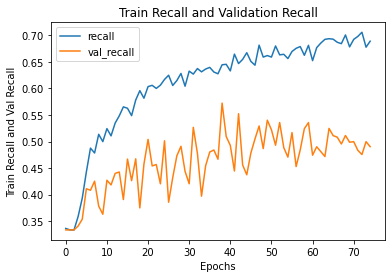

In [101]:
visualize_training_results(results_cnn11)

In [102]:
cnn_11_train_eval_dict = cnn_model_11.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_11_train_eval_dict)

{'recall_macro': 0.689, 'acc_macro': 0.8887}

In [103]:
cnn_11_val_eval_dict = cnn_model_11.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_11_val_eval_dict)

{'recall_macro': 0.5291, 'acc_macro': 0.8448}

In [104]:
cnn_11_test_eval_dict = cnn_model_11.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_11_test_eval_dict)

{'recall_macro': 0.5372, 'acc_macro': 0.8646}

<b>The decrease in the learning rate definitely helped, but CNN-8 is still the best model. Going forward, I will continue with the model CNN-8 architecture, but use some regularization techniques to see if I could further reduce the variance.</b>

## CNN-12 through CNN-17: Try different regularization techniques:

### CNN-12

<b>I will run the same model architecture as in CNN-8, but with a dropout layer of .1, applied to all layers.</b>

In [105]:
tf.random.set_seed(seed)

cnn_model_12 = models.Sequential()
cnn_model_12.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_12.add(layers.Dropout(0.1))
cnn_model_12.add(layers.MaxPooling2D((2, 2)))

cnn_model_12.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_12.add(layers.Dropout(0.1))
cnn_model_12.add(layers.MaxPooling2D((2, 2)))

cnn_model_12.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_12.add(layers.Dropout(0.1))
cnn_model_12.add(layers.MaxPooling2D((2, 2)))

cnn_model_12.add(layers.Conv2D(128, (5, 5), activation='relu'))
cnn_model_12.add(layers.Dropout(0.1))

cnn_model_12.add(layers.Flatten())
cnn_model_12.add(layers.Dense(32, activation='relu'))
cnn_model_12.add(layers.Dropout(0.1))
cnn_model_12.add(layers.Dense(3, activation='sigmoid'))


cnn_model_12.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [106]:
results_cnn12 = cnn_model_12.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 10s - loss: 0.5124 - recall_macro: 0.3369 - acc_macro: 0.8031 - val_loss: 0.4944 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 10s - loss: 0.4880 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4911 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 10s - loss: 0.4806 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.4921 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 10s - loss: 0.4760 - recall_macro: 0.3331 - acc_macro: 0.8097 - val_loss: 0.4806 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 10s - loss: 0.4690 - recall_macro: 0.3361 - acc_macro: 0.8101 - val_loss: 0.4766 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 10s - loss: 0.4653 - recall_macro: 0.3389 - acc_macro: 0.8104 - val_loss: 0.4804 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 10s - loss: 0.4624 - recall_macro: 0.3462 - acc_macro: 0.8102

Epoch 55/75
120/120 - 11s - loss: 0.3302 - recall_macro: 0.6205 - acc_macro: 0.8582 - val_loss: 0.3687 - val_recall_macro: 0.4429 - val_acc_macro: 0.8385
Epoch 56/75
120/120 - 12s - loss: 0.3260 - recall_macro: 0.6301 - acc_macro: 0.8609 - val_loss: 0.3657 - val_recall_macro: 0.4764 - val_acc_macro: 0.8427
Epoch 57/75
120/120 - 12s - loss: 0.3255 - recall_macro: 0.6243 - acc_macro: 0.8634 - val_loss: 0.3730 - val_recall_macro: 0.4248 - val_acc_macro: 0.8411
Epoch 58/75
120/120 - 11s - loss: 0.3247 - recall_macro: 0.6254 - acc_macro: 0.8595 - val_loss: 0.3830 - val_recall_macro: 0.4120 - val_acc_macro: 0.8370
Epoch 59/75
120/120 - 11s - loss: 0.3200 - recall_macro: 0.6235 - acc_macro: 0.8634 - val_loss: 0.3618 - val_recall_macro: 0.5241 - val_acc_macro: 0.8417
Epoch 60/75
120/120 - 11s - loss: 0.3151 - recall_macro: 0.6475 - acc_macro: 0.8670 - val_loss: 0.3640 - val_recall_macro: 0.4869 - val_acc_macro: 0.8401
Epoch 61/75
120/120 - 11s - loss: 0.3211 - recall_macro: 0.6131 - acc_macro:

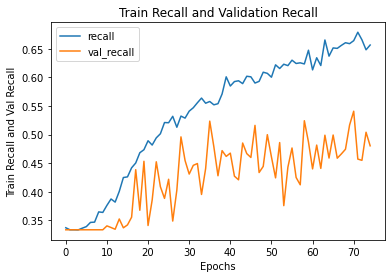

In [107]:
visualize_training_results(results_cnn12)

In [108]:
cnn_12_train_eval_dict = cnn_model_12.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_12_train_eval_dict)

{'recall_macro': 0.6773, 'acc_macro': 0.8891}

In [109]:
cnn_12_val_eval_dict = cnn_model_12.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_12_val_eval_dict)

{'recall_macro': 0.5137, 'acc_macro': 0.8427}

In [110]:
cnn_12_test_eval_dict = cnn_model_12.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_12_test_eval_dict)

{'recall_macro': 0.5368, 'acc_macro': 0.8687}

<b>This actually increased the training score by over 1 point, as compared to CNN-8, while keeping the test score virtually the same; making the variance worse.</b>

### CNN-13

<b>I will run the same model as CNN-12 but with dropout layers of .2 instead of .1 .</b>

In [111]:
tf.random.set_seed(seed)

cnn_model_13 = models.Sequential()
cnn_model_13.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_13.add(layers.Dropout(0.2))
cnn_model_13.add(layers.MaxPooling2D((2, 2)))

cnn_model_13.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_13.add(layers.Dropout(0.2))
cnn_model_13.add(layers.MaxPooling2D((2, 2)))

cnn_model_13.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_13.add(layers.Dropout(0.2))
cnn_model_13.add(layers.MaxPooling2D((2, 2)))

cnn_model_13.add(layers.Conv2D(128, (5, 5), activation='relu'))
cnn_model_13.add(layers.Dropout(0.2))

cnn_model_13.add(layers.Flatten())
cnn_model_13.add(layers.Dense(32, activation='relu'))
cnn_model_13.add(layers.Dropout(0.2))
cnn_model_13.add(layers.Dense(3, activation='sigmoid'))

cnn_model_13.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [112]:
results_cnn13 = cnn_model_13.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 10s - loss: 0.5100 - recall_macro: 0.3367 - acc_macro: 0.8019 - val_loss: 0.5240 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 10s - loss: 0.4931 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.5175 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 10s - loss: 0.4818 - recall_macro: 0.3327 - acc_macro: 0.8099 - val_loss: 0.5167 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 10s - loss: 0.4776 - recall_macro: 0.3357 - acc_macro: 0.8095 - val_loss: 0.5063 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 10s - loss: 0.4675 - recall_macro: 0.3392 - acc_macro: 0.8092 - val_loss: 0.5050 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 10s - loss: 0.4651 - recall_macro: 0.3463 - acc_macro: 0.8106 - val_loss: 0.5128 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 10s - loss: 0.4650 - recall_macro: 0.3491 - acc_macro: 0.8094

Epoch 55/75
120/120 - 10s - loss: 0.3322 - recall_macro: 0.6028 - acc_macro: 0.8571 - val_loss: 0.3891 - val_recall_macro: 0.4642 - val_acc_macro: 0.8443
Epoch 56/75
120/120 - 10s - loss: 0.3309 - recall_macro: 0.6125 - acc_macro: 0.8587 - val_loss: 0.3906 - val_recall_macro: 0.4700 - val_acc_macro: 0.8458
Epoch 57/75
120/120 - 10s - loss: 0.3307 - recall_macro: 0.6161 - acc_macro: 0.8569 - val_loss: 0.3944 - val_recall_macro: 0.4167 - val_acc_macro: 0.8365
Epoch 58/75
120/120 - 10s - loss: 0.3319 - recall_macro: 0.6058 - acc_macro: 0.8559 - val_loss: 0.3968 - val_recall_macro: 0.4484 - val_acc_macro: 0.8385
Epoch 59/75
120/120 - 10s - loss: 0.3250 - recall_macro: 0.6068 - acc_macro: 0.8611 - val_loss: 0.3870 - val_recall_macro: 0.5161 - val_acc_macro: 0.8432
Epoch 60/75
120/120 - 11s - loss: 0.3208 - recall_macro: 0.6430 - acc_macro: 0.8661 - val_loss: 0.3924 - val_recall_macro: 0.4922 - val_acc_macro: 0.8443
Epoch 61/75
120/120 - 11s - loss: 0.3254 - recall_macro: 0.6024 - acc_macro:

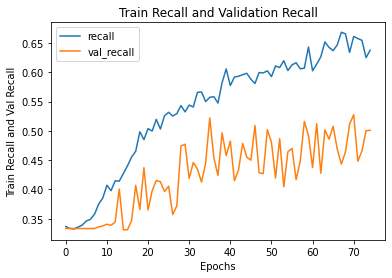

In [113]:
visualize_training_results(results_cnn13)

In [114]:
cnn_13_train_eval_dict = cnn_model_13.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_13_train_eval_dict)

{'recall_macro': 0.6896, 'acc_macro': 0.874}

In [115]:
cnn_13_val_eval_dict = cnn_model_13.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_13_val_eval_dict)

{'recall_macro': 0.5321, 'acc_macro': 0.8401}

In [116]:
cnn_13_test_eval_dict = cnn_model_13.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_13_test_eval_dict)

{'recall_macro': 0.5374, 'acc_macro': 0.8609}

<b>The variance is even worse than CNN-12, which is not as good as CNN-8.</b>

### CNN-14

<b>I will run the same model as CNN-13 but with dropout layers of .3 instead of .2 .</b>

In [117]:
tf.random.set_seed(seed)

cnn_model_14 = models.Sequential()
cnn_model_14.add(layers.Conv2D(16, (2, 2), activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_14.add(layers.Dropout(0.3))
cnn_model_14.add(layers.MaxPooling2D((2, 2)))

cnn_model_14.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_14.add(layers.Dropout(0.3))
cnn_model_14.add(layers.MaxPooling2D((2, 2)))

cnn_model_14.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_14.add(layers.Dropout(0.3))
cnn_model_14.add(layers.MaxPooling2D((2, 2)))

cnn_model_14.add(layers.Conv2D(128, (5, 5), activation='relu'))
cnn_model_14.add(layers.Dropout(0.3))


cnn_model_14.add(layers.Flatten())
cnn_model_14.add(layers.Dense(32, activation='relu'))
cnn_model_14.add(layers.Dropout(0.3))
cnn_model_14.add(layers.Dense(3, activation='sigmoid'))

cnn_model_14.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [118]:
results_cnn14 = cnn_model_14.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 11s - loss: 0.5144 - recall_macro: 0.3340 - acc_macro: 0.8000 - val_loss: 0.5655 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 10s - loss: 0.4974 - recall_macro: 0.3379 - acc_macro: 0.8101 - val_loss: 0.5534 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 11s - loss: 0.4850 - recall_macro: 0.3349 - acc_macro: 0.8069 - val_loss: 0.5498 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 10s - loss: 0.4798 - recall_macro: 0.3398 - acc_macro: 0.8075 - val_loss: 0.5439 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 10s - loss: 0.4711 - recall_macro: 0.3621 - acc_macro: 0.8090 - val_loss: 0.5461 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 10s - loss: 0.4715 - recall_macro: 0.3565 - acc_macro: 0.8094 - val_loss: 0.5557 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 11s - loss: 0.4676 - recall_macro: 0.3628 - acc_macro: 0.8082

Epoch 55/75
120/120 - 10s - loss: 0.3304 - recall_macro: 0.5976 - acc_macro: 0.8542 - val_loss: 0.4204 - val_recall_macro: 0.4519 - val_acc_macro: 0.8380
Epoch 56/75
120/120 - 10s - loss: 0.3339 - recall_macro: 0.6246 - acc_macro: 0.8602 - val_loss: 0.4297 - val_recall_macro: 0.4355 - val_acc_macro: 0.8344
Epoch 57/75
120/120 - 10s - loss: 0.3308 - recall_macro: 0.6187 - acc_macro: 0.8604 - val_loss: 0.4243 - val_recall_macro: 0.3984 - val_acc_macro: 0.8328
Epoch 58/75
120/120 - 10s - loss: 0.3327 - recall_macro: 0.6011 - acc_macro: 0.8571 - val_loss: 0.4282 - val_recall_macro: 0.4311 - val_acc_macro: 0.8365
Epoch 59/75
120/120 - 10s - loss: 0.3267 - recall_macro: 0.6165 - acc_macro: 0.8642 - val_loss: 0.4184 - val_recall_macro: 0.4976 - val_acc_macro: 0.8443
Epoch 60/75
120/120 - 10s - loss: 0.3222 - recall_macro: 0.6410 - acc_macro: 0.8630 - val_loss: 0.4286 - val_recall_macro: 0.4565 - val_acc_macro: 0.8380
Epoch 61/75
120/120 - 10s - loss: 0.3253 - recall_macro: 0.6022 - acc_macro:

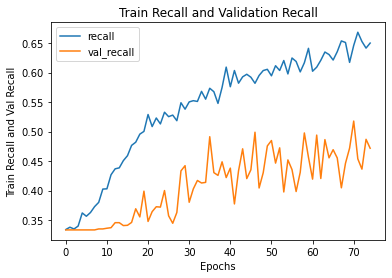

In [119]:
cnn_14_plot = visualize_training_results(results_cnn14)
cnn_14_plot

In [120]:
cnn_14_train_eval_dict = cnn_model_14.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_14_train_eval_dict)

{'recall_macro': 0.6181, 'acc_macro': 0.8575}

In [121]:
cnn_14_val_eval_dict = cnn_model_14.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_14_val_eval_dict)

{'recall_macro': 0.4945, 'acc_macro': 0.8359}

In [122]:
cnn_14_test_eval_dict = cnn_model_14.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_14_test_eval_dict)

{'recall_macro': 0.5301, 'acc_macro': 0.8484}

<b>Compared to CNN-8, the train score has decreased by almost five points, while the test score has only decreased by about half a point. This marks a considerable improvement (decrease) in the variance.</b>

### CNN-15

<b>I will use the same architecture as that of model CNN-14, but instead of using dropout layers, I will use L2(.01) regularization for each layer.</b>

In [123]:
tf.random.set_seed(seed)

cnn_model_15 = models.Sequential()
cnn_model_15.add(layers.Conv2D(16, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu',
                        input_shape=(128,128,  3)))
cnn_model_15.add(layers.MaxPooling2D((2, 2)))

cnn_model_15.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
cnn_model_15.add(layers.MaxPooling2D((2, 2)))

cnn_model_15.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
cnn_model_15.add(layers.MaxPooling2D((2, 2)))

cnn_model_15.add(layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.01), activation='relu'))

cnn_model_15.add(layers.Flatten())
cnn_model_15.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
cnn_model_15.add(layers.Dense(3, activation='sigmoid'))

cnn_model_15.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [124]:
results_cnn15 = cnn_model_15.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 9s - loss: 2.6513 - recall_macro: 0.3361 - acc_macro: 0.8036 - val_loss: 2.5610 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 8s - loss: 2.5127 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 2.4627 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 8s - loss: 2.4173 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 2.3696 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 8s - loss: 2.3263 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 2.2805 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 8s - loss: 2.2392 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 2.1954 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 8s - loss: 2.1561 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 2.1159 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 8s - loss: 2.0777 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 8s - loss: 0.6016 - recall_macro: 0.4393 - acc_macro: 0.8245 - val_loss: 0.6170 - val_recall_macro: 0.3713 - val_acc_macro: 0.8182
Epoch 56/75
120/120 - 8s - loss: 0.5926 - recall_macro: 0.4455 - acc_macro: 0.8210 - val_loss: 0.6089 - val_recall_macro: 0.4814 - val_acc_macro: 0.8255
Epoch 57/75
120/120 - 8s - loss: 0.5852 - recall_macro: 0.4561 - acc_macro: 0.8231 - val_loss: 0.5889 - val_recall_macro: 0.3521 - val_acc_macro: 0.8208
Epoch 58/75
120/120 - 8s - loss: 0.5813 - recall_macro: 0.4516 - acc_macro: 0.8234 - val_loss: 0.5919 - val_recall_macro: 0.3451 - val_acc_macro: 0.8208
Epoch 59/75
120/120 - 8s - loss: 0.5727 - recall_macro: 0.4422 - acc_macro: 0.8240 - val_loss: 0.5758 - val_recall_macro: 0.4109 - val_acc_macro: 0.8255
Epoch 60/75
120/120 - 8s - loss: 0.5615 - recall_macro: 0.4697 - acc_macro: 0.8314 - val_loss: 0.5691 - val_recall_macro: 0.4040 - val_acc_macro: 0.8250
Epoch 61/75
120/120 - 8s - loss: 0.5587 - recall_macro: 0.4492 - acc_macro: 0.8260

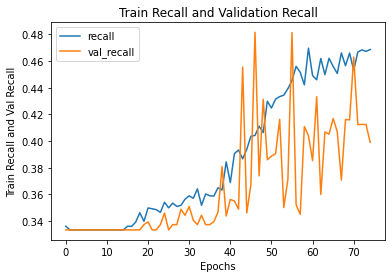

In [125]:
cnn_15_plot = visualize_training_results(results_cnn15)
cnn_15_plot

In [126]:
cnn_15_train_eval_dict = cnn_model_15.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_15_train_eval_dict)

{'recall_macro': 0.4804, 'acc_macro': 0.8182}

In [127]:
cnn_15_val_eval_dict = cnn_model_15.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_15_val_eval_dict)

{'recall_macro': 0.4101, 'acc_macro': 0.8161}

In [128]:
cnn_15_test_eval_dict = cnn_model_15.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_15_test_eval_dict)

{'recall_macro': 0.4701, 'acc_macro': 0.8427}

<b>Interesting results. Both scores went down considerably, relative to CNN-14. The train score, by almost fourteen points, and the test score by almost six. This definitely improves the variance, but I am not sure at what cost to the bias. I will review all the models at the end, to determine which is best.</b>

### CNN-16

<b>I will use the same architecture as that of model CNN-15, but I will decrease the L2 regularization penalty to .0075 for each layer.</b>

In [129]:
tf.random.set_seed(seed)

cnn_model_16 = models.Sequential()
cnn_model_16.add(layers.Conv2D(16, (2, 2),kernel_regularizer=regularizers.l2(0.0075) ,activation='relu',
                        input_shape=(128,128,  3)))
cnn_model_16.add(layers.MaxPooling2D((2, 2)))

cnn_model_16.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.0075) , activation='relu'))
cnn_model_16.add(layers.MaxPooling2D((2, 2)))

cnn_model_16.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.0075), activation='relu'))
cnn_model_16.add(layers.MaxPooling2D((2, 2)))

cnn_model_16.add(layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0075), activation='relu'))

cnn_model_16.add(layers.Flatten())
cnn_model_16.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.0075), activation='relu'))
cnn_model_16.add(layers.Dense(3, activation='sigmoid'))

cnn_model_16.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[recall_macro,acc_macro])

In [130]:
results_cnn16 = cnn_model_16.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 9s - loss: 2.1285 - recall_macro: 0.3361 - acc_macro: 0.8036 - val_loss: 2.0603 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 8s - loss: 2.0327 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 2.0034 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 9s - loss: 1.9775 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 1.9491 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 8s - loss: 1.9240 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 1.8962 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 8s - loss: 1.8720 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 1.8451 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 8s - loss: 1.8216 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 1.7974 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 8s - loss: 1.7737 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 8s - loss: 0.6537 - recall_macro: 0.4808 - acc_macro: 0.8323 - val_loss: 0.6713 - val_recall_macro: 0.3837 - val_acc_macro: 0.8187
Epoch 56/75
120/120 - 8s - loss: 0.6453 - recall_macro: 0.4852 - acc_macro: 0.8306 - val_loss: 0.6618 - val_recall_macro: 0.4582 - val_acc_macro: 0.8344
Epoch 57/75
120/120 - 8s - loss: 0.6367 - recall_macro: 0.4784 - acc_macro: 0.8292 - val_loss: 0.6485 - val_recall_macro: 0.3789 - val_acc_macro: 0.8297
Epoch 58/75
120/120 - 8s - loss: 0.6328 - recall_macro: 0.4905 - acc_macro: 0.8304 - val_loss: 0.6494 - val_recall_macro: 0.3506 - val_acc_macro: 0.8240
Epoch 59/75
120/120 - 8s - loss: 0.6233 - recall_macro: 0.4874 - acc_macro: 0.8302 - val_loss: 0.6290 - val_recall_macro: 0.4432 - val_acc_macro: 0.8286
Epoch 60/75
120/120 - 8s - loss: 0.6109 - recall_macro: 0.5185 - acc_macro: 0.8401 - val_loss: 0.6221 - val_recall_macro: 0.4362 - val_acc_macro: 0.8260
Epoch 61/75
120/120 - 8s - loss: 0.6084 - recall_macro: 0.4804 - acc_macro: 0.8319

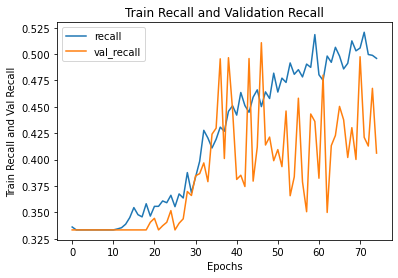

In [131]:
cnn_16_plot = visualize_training_results(results_cnn16)
cnn_16_plot

In [132]:
cnn_16_train_eval_dict = cnn_model_16.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_16_train_eval_dict)

{'recall_macro': 0.5139, 'acc_macro': 0.8286}

In [133]:
cnn_16_val_eval_dict = cnn_model_16.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_16_val_eval_dict)

{'recall_macro': 0.4125, 'acc_macro': 0.8167}

In [134]:
cnn_16_test_eval_dict = cnn_model_16.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_16_test_eval_dict)

{'recall_macro': 0.4796, 'acc_macro': 0.8469}

<b>Relative to CNN-15, the train score has increased about three points. The test score has also increased almost one point, but the variance has increased as well.</b> 

### CNN-17

<b>I will use the same architecture as that of model CNN-16, but I will decrease the L2 regularization penalty to .0025 for each layer.</b>

In [135]:
tf.random.set_seed(seed)

cnn_model_17 = models.Sequential()
cnn_model_17.add(layers.Conv2D(16, (2, 2), kernel_regularizer=regularizers.l2(0.0025),activation='relu',
                        input_shape=(128 ,128,  3)))
cnn_model_17.add(layers.MaxPooling2D((2, 2)))

cnn_model_17.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.0025), activation='relu'))
cnn_model_17.add(layers.MaxPooling2D((2, 2)))

cnn_model_17.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.0025), activation='relu'))
cnn_model_17.add(layers.MaxPooling2D((2, 2)))

cnn_model_17.add(layers.Conv2D(128, (5, 5), kernel_regularizer=regularizers.l2(0.0025), activation='relu'))

cnn_model_17.add(layers.Flatten())
cnn_model_17.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.0025), activation='relu'))
cnn_model_17.add(layers.Dense(3, activation='sigmoid'))

cnn_model_17.compile(loss='binary_crossentropy',
              optimizer= 'sgd',
              metrics=[recall_macro,acc_macro])

In [136]:
results_cnn17 = cnn_model_17.fit(train_images,
                    train_labels,
                    epochs=75,
                    batch_size=16,
                    verbose=2,
                    validation_data=(val_images, val_labels))

Epoch 1/75
120/120 - 9s - loss: 1.0643 - recall_macro: 0.3361 - acc_macro: 0.8036 - val_loss: 1.0215 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 2/75
120/120 - 8s - loss: 1.0185 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 1.0137 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 3/75
120/120 - 8s - loss: 1.0114 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 1.0064 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 4/75
120/120 - 8s - loss: 1.0039 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.9987 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 5/75
120/120 - 8s - loss: 0.9958 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.9904 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 6/75
120/120 - 8s - loss: 0.9872 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_loss: 0.9842 - val_recall_macro: 0.3333 - val_acc_macro: 0.8083
Epoch 7/75
120/120 - 8s - loss: 0.9790 - recall_macro: 0.3333 - acc_macro: 0.8101 - val_

Epoch 55/75
120/120 - 9s - loss: 0.6602 - recall_macro: 0.5576 - acc_macro: 0.8474 - val_loss: 0.6842 - val_recall_macro: 0.4123 - val_acc_macro: 0.8333
Epoch 56/75
120/120 - 9s - loss: 0.6556 - recall_macro: 0.5756 - acc_macro: 0.8493 - val_loss: 0.6767 - val_recall_macro: 0.4678 - val_acc_macro: 0.8438
Epoch 57/75
120/120 - 9s - loss: 0.6508 - recall_macro: 0.5578 - acc_macro: 0.8481 - val_loss: 0.6882 - val_recall_macro: 0.3876 - val_acc_macro: 0.8370
Epoch 58/75
120/120 - 8s - loss: 0.6510 - recall_macro: 0.5795 - acc_macro: 0.8500 - val_loss: 0.6951 - val_recall_macro: 0.3531 - val_acc_macro: 0.8260
Epoch 59/75
120/120 - 9s - loss: 0.6459 - recall_macro: 0.5648 - acc_macro: 0.8481 - val_loss: 0.6613 - val_recall_macro: 0.4931 - val_acc_macro: 0.8391
Epoch 60/75
120/120 - 8s - loss: 0.6364 - recall_macro: 0.5922 - acc_macro: 0.8554 - val_loss: 0.6587 - val_recall_macro: 0.4628 - val_acc_macro: 0.8401
Epoch 61/75
120/120 - 8s - loss: 0.6367 - recall_macro: 0.5524 - acc_macro: 0.8462

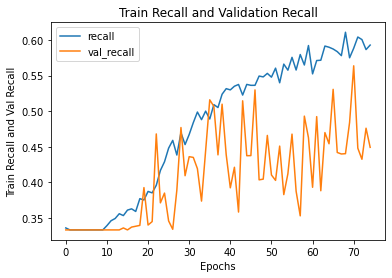

In [137]:
cnn_17_plot = visualize_training_results(results_cnn17)
cnn_17_plot

In [138]:
cnn_17_train_eval_dict = cnn_model_17.evaluate(train_images, train_labels,return_dict=1, verbose=0)
recall_dict(cnn_17_train_eval_dict)

{'recall_macro': 0.5916, 'acc_macro': 0.8569}

In [139]:
cnn_17_val_eval_dict = cnn_model_17.evaluate(val_images, val_labels, return_dict=1, verbose=0)
recall_dict(cnn_17_val_eval_dict)

{'recall_macro': 0.4754, 'acc_macro': 0.8354}

In [140]:
cnn_17_test_eval_dict = cnn_model_17.evaluate(test_images, test_labels, return_dict=1, verbose=0)
recall_dict(cnn_17_test_eval_dict)

{'recall_macro': 0.5034, 'acc_macro': 0.8641}

<b>Both the train and test scores have increased, as compared to CNN-16. This will be my final model. I will review all models in the next section to determine which is best.</b>

#  Choosing The Best Model

<b>After reviewing the 'Best Model' dataframe, and the train and recall validation plots below, there are a few major takeaways:<br>

* The model with the best train/test - bias/variance combination is model cnn-15, based on auc score. 
* Independent of the train score, after around epoch 40 the majority of scores fall between the low 40s and the low     50s, and there is an upward trend across all validation plots. 
* In cnn-10 using the ADAM optimizer with the default learning rate; with the training score at 96%, the validation     score appears to be converging at around .50.
* Not only does model cnn-15 have the highest auc score, it also has the lowest 'train-val-test diff mean', which is     derived when adding the train-test difference, to the train-val difference, and then dividing by 2. This translates   into greater consistency, and lower variance amongst the datasets.<br><br> 

Based on this, I chose cnn-15 as the best model.<br><br>
    
That said, it may be somewhat underfit, but the alternatives, model 14 is considerably overfit, and model 16 raises the train score about 3 points, but the test and val scores increase by less than a point. In addition to this, I didn't like the fact that the difference between the train and val scores (in model 16) were over ten points.</b>  

In [141]:
best_model_df = best_model(18)
best_model_df

,model name,train score,val score,test score,train-val diff,train-test diff,train-val-test diff mean,auc score
15,cnn_model_15,0.480373,0.410101,0.470068,0.070273,0.010306,0.040289,0.729881
16,cnn_model_16,0.513906,0.412502,0.479578,0.101403,0.034327,0.067865,0.722625
14,cnn_model_14,0.618142,0.494490,0.530069,0.123651,0.088072,0.105862,0.720998
17,cnn_model_17,0.591560,0.475409,0.503380,0.116151,0.088180,0.102165,0.707600
8,cnn_model_8,0.665258,0.504604,0.536069,0.160654,0.129189,0.144921,0.703440
2,cnn_model_2,0.620345,0.500123,0.513473,0.120222,0.106872,0.113547,0.703300
12,cnn_model_12,0.677328,0.513701,0.536801,0.163626,0.140526,0.152076,0.698137
1,cnn_model_1,0.647063,0.510564,0.520641,0.136499,0.126421,0.131460,0.697110
5,cnn_model_5,0.685895,0.540509,0.538900,0.145386,0.146995,0.146191,0.695952
11,cnn_model_11,0.688959,0.529084,0.537230,0.159875,0.151729,0.155802,0.692751


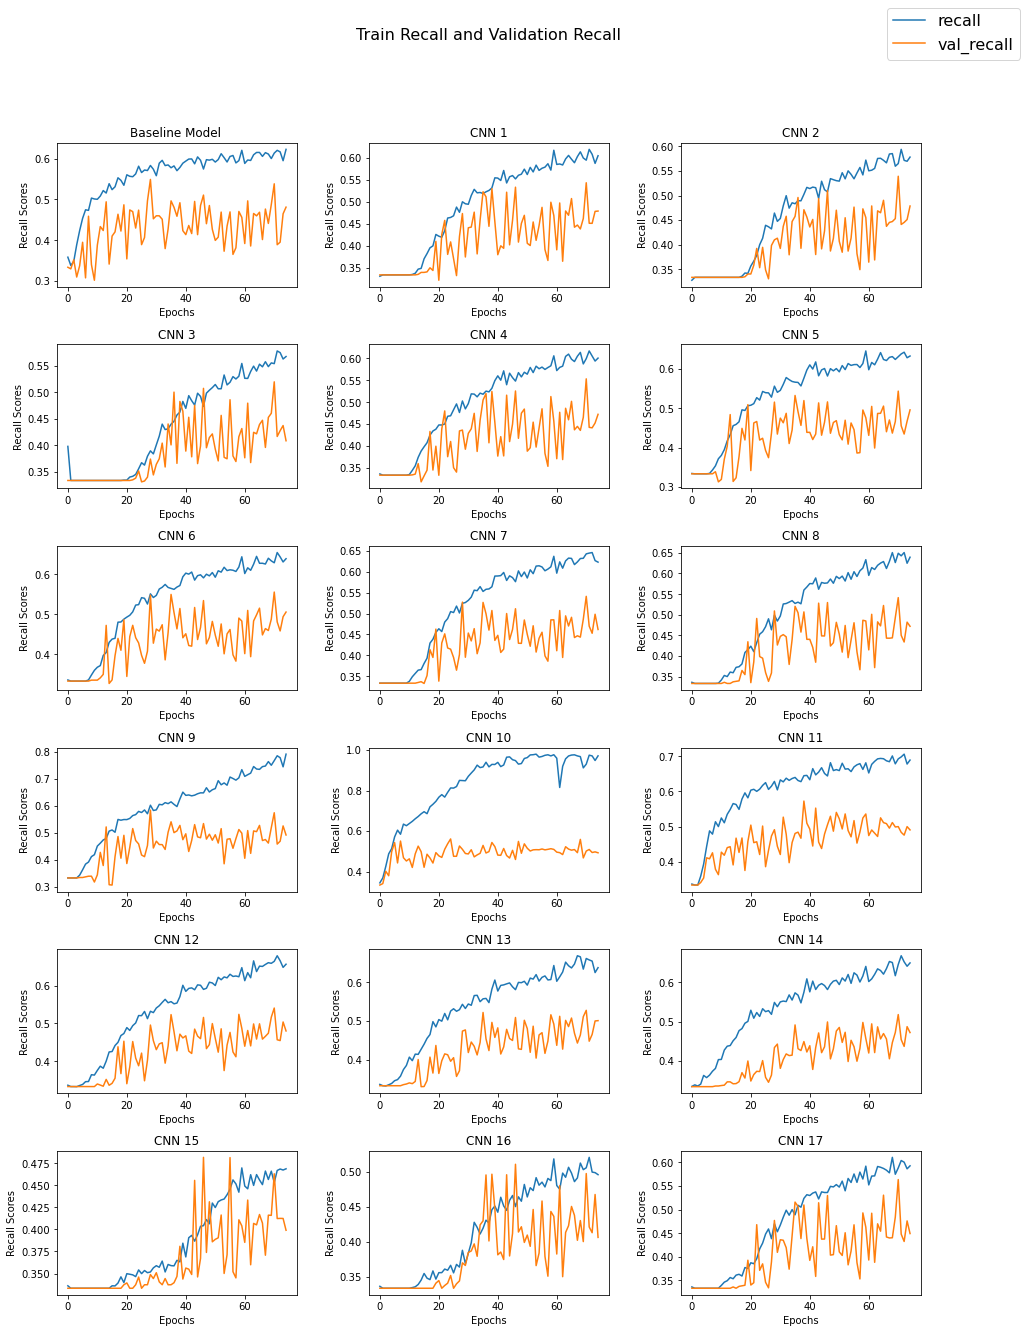

In [142]:
visualize_all_recall_plots()

## Best Model Classification Report and Confusion Matrices:

<b>After reviewing the 'Classification Report', and the confusion matrices (from the test data set) below, there are a few major takeaways:<br>

* The model excels at correctly identifying the respective majority class. 
* The macro average of the three recall scores is .51, which is booned by the recall score of .97 for class zero. 
* For class zero, the model did great at detecting the images classified as having 'Disease Risk', with a recall score   of .97.
* For class one, the model had trouble correctly identifying images classified as having 'Diabetic Retinopathy', with   a recall score of only .04 . 
* For class two, the model did much better at correctly identifying images classified as having 'Media Haze',with a     recall score of .53 . This despite the fact that it was the minority class by a ratio of less than 1:5 . 
* The accuracy scores based on the confusion matrices are the following:
    
        Disease Risk accuracy score         : .84
        Diabetic Retinopathy accuracy score : .81
        Media Haze accuracy score           : .87
        Accuracy Macro Average Score        : .84
    
* More images, especially of 'Diabetic Retinopathy' should help improve the recall scores.</b>

In [143]:
tf.random.set_seed(seed)

# creating numpy array of training set predictions:
test_preds_15 = cnn_model_15.predict(test_images)
test_preds_15 = np.round(test_preds_15)

# making sure that both 'test_preds' and 'test_labels' are type float:
test_preds_15 = test_preds_15.astype(float)
test_labels_15 = test_labels.astype(float)

# Using a loop to divide both the 'test_preds' and 'test_labels' arrays into three parts. One for each class:
for i in range(3):
    globals()['test_preds_15_' + str(i)] = globals()['test_preds_15'][:,i]
    globals()['test_labels_15_' + str(i)] = globals()['test_labels_15'][:,i]

# sklearn's classification report:
class_report = (classification_report(test_labels_15, test_preds_15))
print(class_report)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       506
           1       0.71      0.04      0.08       124
           2       0.63      0.53      0.58       104

   micro avg       0.82      0.75      0.78       734
   macro avg       0.73      0.51      0.52       734
weighted avg       0.80      0.75      0.72       734
 samples avg       0.74      0.64      0.66       734



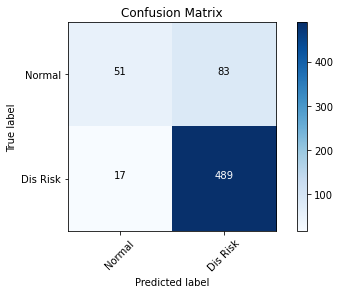

In [144]:
tf.random.set_seed(seed)
#Using a loop to create three confusion matrices. One for each class:
for i in range(3):
    globals()['cm_' + str(i)] = confusion_matrix(y_true=globals()["test_labels_15_" + str(i)],
                                                 y_pred=globals()["test_preds_15_" + str(i)])

# list with the plot labels (required as an argument)
cm_0_plot_labels = ['Normal','Dis Risk']
cm_1_plot_labels = ['Normal','DR']
cm_2_plot_labels = ['Normal','MH']

# plotting confusion matrix:
plot_confusion_matrix(cm=cm_0, classes=cm_0_plot_labels, title='Confusion Matrix')

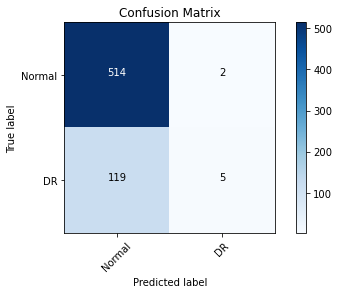

In [145]:
plot_confusion_matrix(cm=cm_1, classes=cm_1_plot_labels, title='Confusion Matrix')

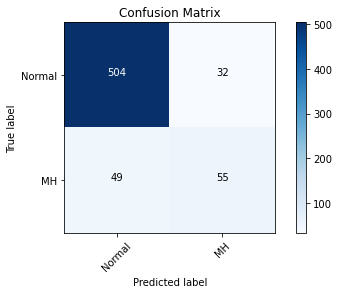

In [146]:
plot_confusion_matrix(cm=cm_2, classes=cm_2_plot_labels, title='Confusion Matrix')

# Project Conclusion: Possible Further Steps

1. Request funding for a larger dataset to further calibrate the model
2. Once the model is ready, we can implement it in a subset of hospitals, use the feedback to make more changes if necessary, and then expand its use from there.

# Appendix: Images for Powerpoint Presentation

## Plot Image Distribution 

In [147]:
to_concat = [train_df,test_df,val_df]
big_df = pd.concat(to_concat)
print('Disease_Risk: ',big_df['Disease_Risk'].sum())
print('DR: ',big_df['DR'].sum())
print('MH: ',big_df['MH'].sum())

Disease_Risk:  2531
DR:  632
MH:  523


In [148]:
big_df.head(5)

,Disease_Risk,DR,MH
0,1,1,0
1,1,1,0
2,1,1,0
3,1,0,1
4,1,1,0


In [149]:
tf.random.set_seed(seed)

# creating a seperate set of labels to work with:
train_labels_to_plt  = train_labels
val_labels_to_plt  = val_labels
test_labels_to_plt  = test_labels

# Using a loop to divide both the 'train_preds' and 'train_labels' arrays into three parts. One for each class:
for i in range(3):
    globals()['train_labels_to_plt_' + str(i)] = globals()['train_labels_to_plt'][:,i]
    globals()['val_labels_to_plt_' + str(i)] = globals()['val_labels_to_plt'][:,i]
    globals()['test_labels_to_plt_' + str(i)] = globals()['test_labels_to_plt'][:,i]

In [150]:
val_labels_to_plt_0.sum() + test_labels_to_plt_0.sum() + train_labels_to_plt_0.sum()

2531

In [151]:
val_labels_to_plt_1.sum() + test_labels_to_plt_1.sum() + train_labels_to_plt_1.sum()

632

In [152]:
val_labels_to_plt_2.sum() + test_labels_to_plt_2.sum() + train_labels_to_plt_2.sum()

523

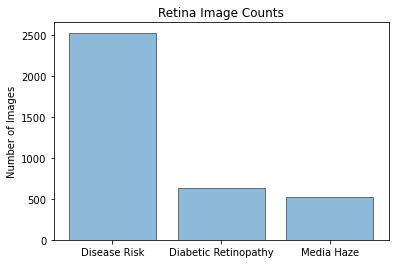

In [153]:
#import matplotlib.pyplot as plt; plt.rcdefaults()
#import numpy as np
import matplotlib.pyplot as plt

objects = ('Disease Risk', 'Diabetic Retinopathy', 'Media Haze')
y_pos = np.arange(len(objects))
performance = [2531,632.0,523.0]

plt.bar(y_pos, performance, alpha=0.5, edgecolor='black')
plt.xticks(y_pos, objects)
plt.ylabel('Number of Images')
plt.title('Retina Image Counts')

plt.show()

#This includes 1583 'normal' images, and 4273 'pneumonia' images.

## Lime Explanantions

<b>I will:
1. Choose three retina images. One each: normal(no disease), diabetic retinopathy('DR'), and media haze('MH'). The        images should meet the following criteria:<br>
   1. The image class must have been predicted correctly by the model.
   2. If 'Disease Risk'is 0, then all the columns should be 0 (the 'Totals' column should equal 0).
   3. If either 'DR' or 'MH' are predicted, the totals column should be equal to 2, with the other predicted column being         'Disease Risk'.<br>

2. Use Lime to 'explain' why a particular class was chosen.</b>
       
   

### Selecting the Images:

In [154]:
# creating a numpy array of train set image predictions based on the Best Model'(CNN-15):
train_preds_15 = cnn_model_15.predict(train_images)
train_preds_15 = np.round(train_preds_15).astype(int)


# creating a list of the row numbers where the numpy arrays for the 'preds' and the 'labels' are an exact match:
idx = 0
new_index = []
while idx < 1920:
    if (train_labels[idx] == train_preds_15[idx]).sum() == 3:
        new_index.append(idx)
    idx+=1

    
print('train_preds_15_df:', train_preds_15.shape)
print('train_labels shape:', train_labels.shape)
print ('new_index length: ', len(new_index))

train_preds_15_df: (1920, 3)
train_labels shape: (1920, 3)
new_index length:  935


In [155]:
# creating a numpy array from the original 'train' dataframe, with all the columns except 'ID'.

# dropping 'ID' column from the dataframe:
train_df_complete = train_df_original.drop(['ID'], axis=1)
# creating a list of column names without 'ID': 
cols_list = train_df_complete.columns
# converting dataframe to a numpy array
train_np_complete = train_df_complete.to_numpy()


# creating a new array that only contains the rows from train_np_complete' that match the index numbers of the
# new_index array, then converting that array into a dataframe.
new_arr = []
for idx in new_index:
    new_arr.append(train_np_complete[idx])
preds15_new_df = pd.DataFrame(new_arr, columns = cols_list, index=new_index)


# adding a 'Totals' column to the new dataframe, that displays the sum of all the column values for each row:
preds15_new_df['Totals'] = preds15_new_df.sum(axis=1)
preds15_new_df.sort_values(by=['Totals'])


print ('preds15_new_df shape: ', preds15_new_df.shape)

preds15_new_df shape:  (935, 47)


<b>Based on the criteria above. Using the dataframe below, I have chosen the following images for the Lime explanations:

 * normal image                   : image 1920
 * diabetic retinopathy image 'DR": image 1347
 * media haze image 'DR"          : image 657
    
Update: After reviewing the three images and their corresponding 'explanations', I decides to use only one of the images (diabetic retinopathy), and 'explain' the three labels for that image. 
    
Note: the image 'ID' is one more than the image index</b>

In [156]:
preds15_new_df.sort_values(by=['Totals'], ascending=True)

,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,Totals
1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1731,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
471,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
361,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
982,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5


### 'Explaining' the Images:

#### View Diabetic Retinopathy Image:

diabetic retinopathy image
image shape: (128, 128, 3)


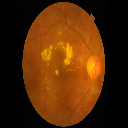

In [157]:
# view an image of 'healthy' retina
DR_img_1447 = image.load_img('archive/Training_Set/Training_Set/Training/1347.png',target_size=(128,128,3))
DR_img = image.img_to_array(DR_img_1447)
DR_img = DR_img/255
print('diabetic retinopathy image')
print('image shape:', DR_img.shape)
DR_img_1447


In [158]:
# creating a LimeImageExplainer() object:
explainer_1 = lime_image.LimeImageExplainer()
# creating an instance of an explainer
explanation_1 = explainer_1.explain_instance(DR_img, cnn_model_15.predict,
                                           top_labels=3, num_samples=5000,random_seed=seed)

In [159]:
train_preds15_DR = cnn_model_15.predict(train_images)
print('probabilities for each class: ',train_preds15_DR[1346])  
print('explanation_1.top_labels: ',explanation_1.top_labels)

probabilities for each class:  [0.83338404 0.5018413  0.04284373]
explanation_1.top_labels:  [0, 1, 2]


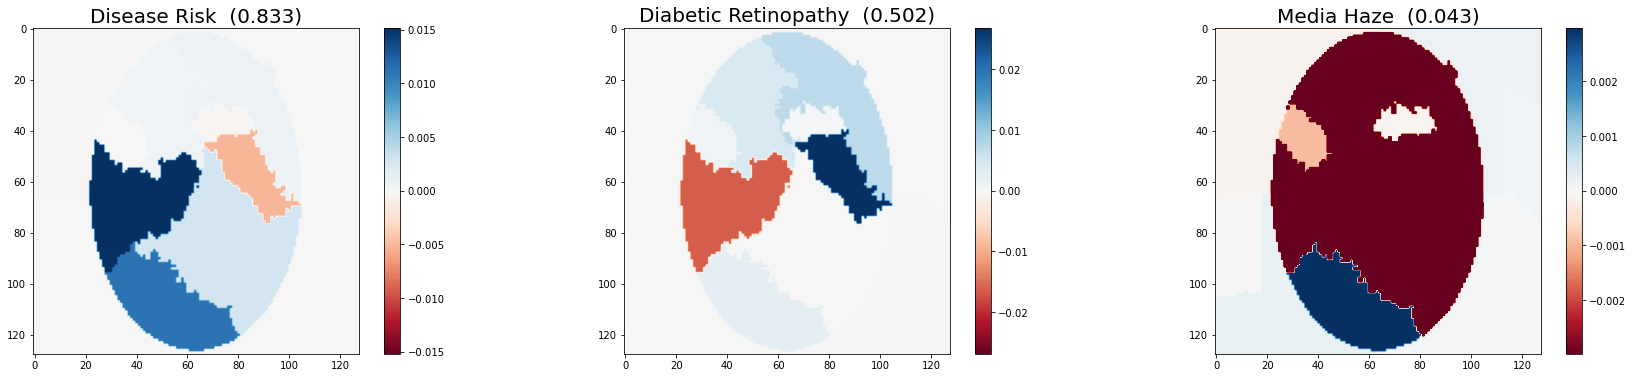

In [160]:
fig1, axs1 = plt.subplots(1, 3,sharex=False,sharey=False, figsize=(30, 6))
labels = ['Disease Risk  (0.833)','Diabetic Retinopathy  (0.502)','Media Haze  (0.043)']

for i in range (3):
#Select the same class explained on the figures above.
    ind =  explanation_1.top_labels[i]

#Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation_1.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation_1.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
    retina_cmap = plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    #plt.colorbar()
    
    axs1[i].set_title(labels[i], fontsize=20)
    axs1[i].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar(retina_cmap, ax=axs1[i])